In [1]:
# Analysis of Imbalance Ratio Effects on Loss Landscape and Overfitting

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Generator, Union
from scipy.interpolate import interpn

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# Set TensorFlow deterministic operations
tf.config.experimental.enable_op_determinism()
# Set Python's random seed
import random
random.seed(42)
# Set environment variables for reproducibility
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'

In [2]:
def compute_loss_landscape(
    model: tf.keras.Model, 
    X: np.ndarray, y: np.ndarray,
    w1_range: Tuple[float, float] = (-5, 5),
    w2_range: Tuple[float, float] = (-5, 5),
    grid_size: float = 0.001,  # Size of each grid cell for high resolution
    batch_size: int = 1000  # Process parameters in batches for speed
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the loss landscape by varying the two model weights.
    
    Args:
        model: TensorFlow model with exactly 2 weights
        X, y: Dataset to compute loss on
        w1_range: Range for first weight parameter
        w2_range: Range for second weight parameter
        grid_size: Size of each grid cell for more detailed landscape
        batch_size: Number of parameter combinations to process at once
        
    Returns:
        Grid of parameter values and corresponding losses
    """
    # Check if the model has exactly 2 trainable parameters
    total_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    if total_params != 2:
        raise ValueError(f"This function only works with models having exactly 2 trainable parameters. "
                         f"The provided model has {total_params} parameters.")
    
    # Calculate number of points based on grid size
    resolution_w1 = int((w1_range[1] - w1_range[0]) / grid_size) + 1
    resolution_w2 = int((w2_range[1] - w2_range[0]) / grid_size) + 1
    
    # Create parameter grid
    w1_vals = np.linspace(w1_range[0], w1_range[1], resolution_w1)
    w2_vals = np.linspace(w2_range[0], w2_range[1], resolution_w2)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    
    # Original parameters
    original_w = model.trainable_variables[0].numpy().copy()
    
    # Convert data to tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # Compute loss for each parameter combination
    Z = np.zeros_like(W1)
    
    # Flatten parameter grid for batch processing
    param_combinations = np.column_stack((W1.flatten(), W2.flatten()))
    total_combinations = len(param_combinations)
    
    # Process in batches
    for i in range(0, total_combinations, batch_size):
        # Get current batch of parameters
        batch_params = param_combinations[i:min(i+batch_size, total_combinations)]
        batch_losses = []
        
        # Process each parameter set in the batch
        for params in batch_params:
            w1, w2 = params
            # Set model parameters
            model.trainable_variables[0].assign([[w1], [w2]])
            
            # Compute loss
            y_pred = model(X_tf, training=False)
            loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_tf, -1)))
            batch_losses.append(float(loss.numpy()))
        
        # Store batch results
        start_idx = i
        end_idx = min(i+batch_size, total_combinations)
        flat_indices = np.arange(start_idx, end_idx)
        
        # Convert flat indices back to 2D indices
        rows = flat_indices // W1.shape[1]
        cols = flat_indices % W1.shape[1]
        
        # Update Z matrix with computed losses
        for k, (r, c) in enumerate(zip(rows, cols)):
            Z[r, c] = batch_losses[k]
    
    # Restore original parameters
    model.trainable_variables[0].assign(original_w)
    
    return W1, W2, Z

def plot_loss_landscape(
    W1: np.ndarray, 
    W2: np.ndarray, 
    Z: np.ndarray, 
    param_history: Optional[np.ndarray] = None,
    title: str = "Loss Landscape") -> None:
    """
    Plot the loss landscape with optional training trajectory.
    
    Args:
        W1, W2: Parameter grid for the two weights
        Z: Loss values at each point in the grid
        param_history: Optional trajectory of parameters during training
        title: Plot title
    """
    # Create a figure with 4 subplots (1 wide 2D at top, 3 3D views at bottom)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 2])
    
    # 2D contour plot (wide, spanning all columns at top)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Use a high-contrast colormap (red-blue)
    cmap = plt.cm.RdBu_r
    
    # Plot loss landscape as contour with high contrast
    contour = ax1.contourf(W1, W2, Z, 50, cmap=cmap)
    plt.colorbar(contour, ax=ax1, label='Loss (MSE)')
    
    # Add contour lines
    contour_lines = ax1.contour(W1, W2, Z, 15, colors='black', alpha=0.5, linewidths=0.5)
    ax1.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot optimization trajectory if provided
    if param_history is not None:
        ax1.plot(param_history[:, 0], param_history[:, 1], 'lime', linewidth=2, alpha=0.7)
        ax1.scatter(param_history[0, 0], param_history[0, 1], c='blue', s=100, 
                  label='Start', zorder=10)
        ax1.scatter(param_history[-1, 0], param_history[-1, 1], c='red', s=100, 
                  label='End', zorder=10)
    
    ax1.set_title(f"2D {title}")
    ax1.set_xlabel('Weight 1 (w1)')
    ax1.set_ylabel('Weight 2 (w2)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 3D surface plots with different viewing angles
    view_angles = [(30, 45), (0, 0), (60, 30)]
    
    for i, angles in enumerate(view_angles):
        ax = fig.add_subplot(gs[1, i], projection='3d')
        
        # Plot surface with high contrast colormap
        surface = ax.plot_surface(W1, W2, Z, cmap=cmap, alpha=0.8,
                                rstride=1, cstride=1, linewidth=0, antialiased=True)
        
        # Plot optimization trajectory in 3D if provided
        if param_history is not None:
            # Get Z values for the trajectory points by interpolating
            points = (np.linspace(W1.min(), W1.max(), W1.shape[0]), 
                     np.linspace(W2.min(), W2.max(), W2.shape[0]))
            trajectory_z = interpn(points, Z, 
                                  param_history[:, [0, 1]], 
                                  method='linear', 
                                  bounds_error=False, 
                                  fill_value=None)
            
            ax.plot(param_history[:, 0], param_history[:, 1], trajectory_z, 
                    'lime', linewidth=2, alpha=0.7)
            ax.scatter(param_history[0, 0], param_history[0, 1], trajectory_z[0], 
                       c='blue', s=100, zorder=10)
            ax.scatter(param_history[-1, 0], param_history[-1, 1], trajectory_z[-1], 
                       c='red', s=100, zorder=10)
        
        # Set view angle for this subplot
        ax.view_init(elev=angles[0], azim=angles[1])
        
        # Add a wireframe to better visualize bumps and jumps
        ax.plot_wireframe(W1, W2, Z, color='black', alpha=0.1, rstride=10, cstride=10)
        
        ax.set_title(f"3D View (elev={angles[0]}°, azim={angles[1]}°)")
        ax.set_xlabel('Weight 1 (w1)')
        ax.set_ylabel('Weight 2 (w2)')
        ax.set_zlabel('Loss (MSE)')
    
    plt.tight_layout()
    plt.show()

In [3]:
def compute_gradient(
    model: tf.keras.Model,
    X_batch: tf.Tensor,
    y_batch: tf.Tensor,
    sample_weights_batch: Optional[tf.Tensor] = None,
    debug: bool = False
) -> List[tf.Tensor]:
    """
    Compute the gradient of MSE loss w.r.t. model parameters for a given batch.
    If sample_weights_batch is provided, applies them to individual losses.
    
    Args:
        model: The TensorFlow model
        X_batch: Batch of features (tf.Tensor)
        y_batch: Batch of targets (tf.Tensor)
        sample_weights_batch: Optional batch of sample-weights (tf.Tensor). assumed to not be probabilities.
        debug: Whether to print debug information (default: False)
        
    Returns:
        A list of gradients (one element per trainable variable)
    """
    # Start gradient tape to track operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Get model predictions (forward pass)
        y_pred = model(X_batch, training=True)
        if debug:
            print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
            print(f"y_pred shape: {y_pred.shape}")
        
        # Calculate squared error for each sample
        # expand_dims adds an axis to y_batch to match y_pred's shape (which has a final dimension for output features)
        y_batch_expanded = tf.expand_dims(y_batch, -1)
        if debug:
            print(f"y_batch_expanded shape: {y_batch_expanded.shape}")
        
        losses = tf.square(y_pred - y_batch_expanded)
        if debug:
            print(f"losses shape: {losses.shape}")
        
        # Apply sample weights if provided
        # This allows giving different importance to different samples in the batch
        if sample_weights_batch is not None:
            # expand_dims allows broadcasting when multiplying
            weights_expanded = tf.expand_dims(sample_weights_batch, -1)
            if debug:
                print(f"sample_weights_batch shape: {sample_weights_batch.shape}")
                print(f"weights_expanded shape: {weights_expanded.shape}")
            losses *= weights_expanded
            if debug:
                print(f"weighted losses shape: {losses.shape}")
        
        # Calculate mean loss across the batch
        loss = tf.reduce_mean(losses)
        if debug:
            print(f"final loss shape: {loss.shape}")
    
    # Compute gradients of loss with respect to all trainable variables
    # Returns a list of tensors (one per trainable variable)
    grads = tape.gradient(loss, model.trainable_variables)
    if debug:
        print(f"Number of gradient tensors: {len(grads)}")
        for i, g in enumerate(grads):
            print(f"grad[{i}] shape: {g.shape}")
    return grads

# Helper function to flatten and concatenate all gradients into a single vector
def flatten_concat(grad_list, debug=False):
    """
    Flatten and concatenate all gradients into a single vector.
    
    Args:
        grad_list: List of gradient tensors
        debug: Whether to print debug information (default: False)
    
    Returns:
        A single vector containing all flattened gradients
    """
    # Filter out None gradients (which can happen if a variable isn't used in computation)
    filtered_grads = [g for g in grad_list if g is not None]
    
    if debug:
        print(f"Number of gradient tensors: {len(filtered_grads)}")
        for i, g in enumerate(filtered_grads):
            print(f"  grad[{i}] shape before reshaping: {g.shape}")
    
    # Reshape each gradient tensor to a flat vector and concatenate all
    flattened = [tf.reshape(g, [-1]) for g in filtered_grads]
    if debug:
        for i, f in enumerate(flattened):
            print(f"  flattened[{i}] shape: {f.shape}")
    
    # Concatenate all flattened gradients into a single vector
    result = tf.concat(flattened, axis=0)
    if debug:
        print(f"Concatenated gradient vector shape: {result.shape}")
    return result


def cosine_similarity(
    grads1: List[tf.Tensor],
    grads2: List[tf.Tensor],
    debug: bool = False
) -> float:
    """
    Compute the cosine similarity between two gradient lists.
    Each list is the set of gradients for the model variables.
    
    Cosine similarity measures the angle between two vectors:
    cos(θ) = (v1·v2)/(||v1||·||v2||)
    
    It ranges from -1 (opposite directions) to 1 (same direction),
    with 0 indicating orthogonal vectors.
    
    Args:
        grads1: List of tf.Tensors (gradients from group 1)
        grads2: List of tf.Tensors (gradients from group 2)
        debug: Whether to print debug information (default: False)
        
    Returns:
        The scalar cosine similarity between grads1 and grads2.
        If both gradients are zero vectors, returns 1.0 (maximally similar).
        If only one gradient is zero while the other is non-zero, returns 0.0.
    """

    
    # Flatten and concatenate gradients from each list
    if debug:
        print("Processing grads1:")
    v1 = flatten_concat(grads1, debug=debug)
    if debug:
        print(f"Gradient vector 1 shape: {v1.shape}")
        print("Processing grads2:")
    v2 = flatten_concat(grads2, debug=debug)
    if debug:
        print(f"Gradient vector 2 shape: {v2.shape}")
    
    # Calculate L2 norms (magnitude) of the gradient vectors
    norm1 = tf.norm(v1)
    norm2 = tf.norm(v2)
    if debug:
        print(f"Gradient vector norms: {norm1:.6f}, {norm2:.6f}")
    
    # Handle edge cases: zero gradients
    # Two zero vectors are considered maximally similar (cos_sim = 1.0)
    # If only one is zero, they're considered orthogonal (cos_sim = 0.0)
    if norm1 < 1e-15 and norm2 < 1e-15:
        if debug:
            print("Both gradient vectors are effectively zero, returning similarity = 1.0")
        return 1.0
    elif norm1 < 1e-15 or norm2 < 1e-15:
        if debug:
            print("One gradient vector is effectively zero, returning similarity = 0.0")
        return 0.0
    
    # Calculate cosine similarity: dot product divided by product of norms
    # Calculate dot product using element-wise multiplication and sum
    dot_product = tf.reduce_sum(v1 * v2)
    if debug:
        print(f"Dot product: {dot_product:.6f}")
    
    cos_sim = dot_product / (norm1 * norm2)
    if debug:
        print(f"Cosine similarity: {cos_sim:.6f}")
    
    # Convert to Python float and return
    return float(cos_sim.numpy())

In [4]:
def stratified_batch_dataset(
        X: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        sample_weights: Optional[np.ndarray] = None,
        shuffle: bool = True
) -> Tuple[tf.data.Dataset, int]:
    """
    Creates a TensorFlow dataset from the stratified data generator, with groups generated only once.

    Parameters:
    -----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    batch_size : int
        Number of samples in each batch.
    sample_weights : Optional[np.ndarray], optional
        Sample weights of shape (n_samples,). If None, no sample weights will be used.
    shuffle : bool, optional
        If True, shuffles the groups and the elements within each group before each epoch (default is True).

    Returns:
    --------
    Tuple[tf.data.Dataset, int]:
        - A TensorFlow dataset object with stratified batches.
        - The number of steps per epoch (i.e., how many batches per epoch).
    """
    # Generate the stratified groups once
    groups = stratified_groups(y, batch_size)

    # Use from_generator to create a dataset from the stratified_data_generator
    if sample_weights is not None:
        # Dataset with sample weights
        dataset = tf.data.Dataset.from_generator(
            lambda: stratified_data_generator(X, y, groups, sample_weights=sample_weights, shuffle=shuffle),
            output_signature=(
                tf.TensorSpec(shape=(batch_size, X.shape[1]), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)  # Sample weights
            )
        )
    else:
        # Dataset without sample weights
        dataset = tf.data.Dataset.from_generator(
            lambda: stratified_data_generator(X, y, groups, sample_weights=None, shuffle=shuffle),
            output_signature=(
                tf.TensorSpec(shape=(batch_size, X.shape[1]), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
            )
        )
    
    # Compute the number of steps per epoch
    steps_per_epoch = len(y) // batch_size
    # Prefetch for performance optimization
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, steps_per_epoch

def stratified_groups(y: np.ndarray, batch_size: int, debug: bool = False) -> np.ndarray:
    """
    Create stratified groups from the dataset by sorting it based on the labels.
    The number of groups corresponds to the batch size, and each group will have
    samples with similar label distributions. The result is a 2D array where each
    group is padded to the same size. Verified to work.

    Parameters:
    -----------
    y : np.ndarray
        Label vector of shape (n_samples, 1).
    batch_size : int
        Number of groups, which will correspond to the number of samples in each batch.

    Returns:
    --------
    np.ndarray:
        A 2D array where each row represents a stratified group, and all rows have the same length.
    """
    # Sort the dataset along the second dimension (axis=0)
    sorted_indices = np.argsort(y, axis=0).flatten()

    # Debugging: Check the shape of y and print sorted indices
    if debug:
        print(f"Shape of y: {y.shape}")
        print(f"Unique values in y: {np.unique(y)}")
        print(f"Sorted indices: {sorted_indices}")
        print(f"Labels sorted by indices: {y[sorted_indices].flatten()}")  # To see how the labels are sorted

    # Create groups by slicing the sorted data indices
    groups = np.array_split(sorted_indices, batch_size)

    # Find the maximum group size
    max_size = max(len(group) for group in groups)

    # Pad the groups with their last element to make all groups the same size
    padded_groups = np.array([
        np.pad(group, (0, max_size - len(group)), 'edge') for group in groups
    ])

    return padded_groups


def stratified_data_generator(
        X: np.ndarray,
        y: np.ndarray,
        groups: np.ndarray,  # Assuming groups is a 2D array
        sample_weights: Optional[np.ndarray] = None,
        shuffle: bool = True,
        debug: bool = False
) -> Generator[Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]], None, None]:
    """
    Generator that yields stratified batches of (X, y) or (X, y, sample_weights) by selecting one sample from each group.
    The groups are passed as a 2D array of sample indices.

    Parameters:
    -----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    groups : np.ndarray
        Precomputed groups of sample indices for stratified sampling, shape (n_groups, group_size).
    sample_weights : Optional[np.ndarray], optional
        Sample weights of shape (n_samples,). If None, no sample weights will be included in yield.
    shuffle : bool, optional
        If True, shuffles the groups and the elements within each group before each epoch (default is True).
    debug : bool, optional
        If True, prints the generated batches for debugging purposes (default is False).

    Yields:
    -------
    Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]]:
        If sample_weights is None:
            Batches of feature matrix and label vector of size (batch_size, n_features) and (batch_size,)
        Otherwise:
            Batches of feature matrix, label vector, and sample weights of size 
            (batch_size, n_features), (batch_size,), and (batch_size,)
    """

    while True:
        if shuffle: np.apply_along_axis(np.random.shuffle, 1, groups)  # Shuffle within each group (columns)
        # Select the first element from each group to form the batch
        batch_indices = groups[:, 0]

        # Optionally, shuffle the order of the selected samples to randomize batch order
        np.random.shuffle(batch_indices)

        # Create the feature and label batches using the selected indices
        batch_X = X[batch_indices]
        batch_y = y[batch_indices]

        # Ensure the labels have the correct shape
        batch_y = batch_y.reshape(-1)

        # Debugging: Print the current batch
        if debug:
            print(f'Batch shape: {batch_X.shape}, {batch_y.shape}')
            print(f"Batch indices: {batch_indices}")
            if sample_weights is not None:
                print(f"Batch sample weights shape: {sample_weights[batch_indices].shape}")

        # Yield the batch with or without sample weights
        if sample_weights is not None:
            batch_weights = sample_weights[batch_indices]
            yield batch_X, batch_y, batch_weights
        else:
            yield batch_X, batch_y

In [5]:
def plot_training_curves(history: Dict[str, List[float]], title: str = "Training and Validation Loss") -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.show()


def plot_grad_cos_similarity(
    grad_cos_sim: List[float],
    title: str = "Gradient Cosine Similarity (Freq vs. Rare)"
) -> None:
    """
    Plot the gradient cosine similarity (freq vs. rare) for each training iteration.
    
    Args:
        grad_cos_sim: List of cosine similarities per iteration (batch)
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Plot raw data with transparency
    plt.plot(grad_cos_sim, label='Raw Similarity', linewidth=1, alpha=0.4, color='blue')
    
    # Add trend line (moving average)
    window_size = min(25, len(grad_cos_sim) // 10)  # Adaptive window size
    if window_size > 0:
        trend = np.convolve(grad_cos_sim, np.ones(window_size)/window_size, mode='valid')
        # Pad the trend line to match original data length
        pad_size = len(grad_cos_sim) - len(trend)
        trend_padded = np.pad(trend, (pad_size, 0), 'edge')
        plt.plot(trend_padded, label='Trend', linewidth=2.5, color='darkblue')
    
    plt.title(title)
    plt.xlabel("Iteration (batch)")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [24]:
def create_simple_model(weight_decay: float = 0.01) -> tf.keras.Model:
    """
    Create a simple neural network with a hidden layer and weight decay regularization.
    
    Args:
        weight_decay: L2 regularization factor for weight decay
    
    Returns:
        A TensorFlow model with a hidden layer using LeakyReLU activation and weight decay
    """
    regularizer = tf.keras.regularizers.l2(weight_decay)
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(
            2,
            use_bias=True,
            activation=None,
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer
        ),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(
            1, 
            use_bias=True, 
            activation=None, 
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer
        )
    ])

    # print the model summary
    # model.summary()
    
    # The model now has more parameters due to the hidden layer
    # We no longer need to verify the exact parameter count
    
    return model

In [7]:
def plot_dataset(
        X: np.ndarray, 
        y: np.ndarray, 
        X_val: np.ndarray, 
        y_val: np.ndarray,  
        y_threshold: float,
        freq_max_radius: float = 0.5,
        title: str = "Dataset Visualization",
        debug: bool = False
    ) -> None:
        """
        Plot the dataset showing frequent and rare samples based on a threshold value.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            X_val: Validation feature array of shape (n_samples, 2)
            y_val: Validation target array of shape (n_samples,)
            y_threshold: Threshold value for y to distinguish between frequent (y <= threshold) 
                        and rare (y > threshold) samples
            freq_max_radius: Radius to draw circle for visual reference
            title: Plot title
            debug: Whether to print debug information about dataset composition
        """
        # Create masks based on y threshold
        freq_mask = y <= y_threshold
        rare_mask = ~freq_mask
        
        # Create masks for validation data
        val_freq_mask = y_val <= y_threshold
        val_rare_mask = ~val_freq_mask
        
        # Print debug information if requested
        if debug:
            print(f"Training set composition:")
            print(f"  Frequent samples: {np.sum(freq_mask)}")
            print(f"  Rare samples: {np.sum(rare_mask)}")
            print(f"Validation set composition:")
            print(f"  Frequent samples: {np.sum(val_freq_mask)}")
            print(f"  Rare samples: {np.sum(val_rare_mask)}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # First subplot: Training data
        # Plot frequent samples
        scatter1 = ax1.scatter(
            X[freq_mask, 0], X[freq_mask, 1], 
            c=y[freq_mask], cmap='Blues', s=50, alpha=0.8,
            label=f'Frequent ({np.sum(freq_mask)} samples)'
        )
        
        # Plot rare samples
        scatter2 = ax1.scatter(
            X[rare_mask, 0], X[rare_mask, 1], 
            c=y[rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
            label=f'Rare ({np.sum(rare_mask)} samples)')
        
        fig.colorbar(scatter1, ax=ax1, label='Target value (distance to center + noise)')
        ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        # Draw circle at specified radius for visual reference
        circle1 = plt.Circle((0, 0), freq_max_radius, fill=False, color='green', linestyle='--')
        ax1.add_patch(circle1)
        
        ax1.set_title(f"Training {title}")
        ax1.set_xlabel('X coordinate')
        ax1.set_ylabel('Y coordinate')
        ax1.legend()
        ax1.axis('equal')
        ax1.grid(alpha=0.3)
        
        # Second subplot: Validation data
        # Plot frequent validation samples
        scatter3 = ax2.scatter(
            X_val[val_freq_mask, 0], X_val[val_freq_mask, 1], 
            c=y_val[val_freq_mask], cmap='Blues', s=50, alpha=0.8,
            label=f'Frequent validation ({np.sum(val_freq_mask)} samples)')
        
        # Plot rare validation samples
        scatter4 = ax2.scatter(
            X_val[val_rare_mask, 0], X_val[val_rare_mask, 1], 
            c=y_val[val_rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
            label=f'Rare validation ({np.sum(val_rare_mask)} samples)')
        
        fig.colorbar(scatter3, ax=ax2, label='Target value (distance to center + noise)')
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        # Draw circle at specified radius for visual reference
        circle2 = plt.Circle((0, 0), freq_max_radius, fill=False, color='green', linestyle='--')
        ax2.add_patch(circle2)
        
        ax2.set_title(f"Validation")
        ax2.set_xlabel('X coordinate')
        ax2.set_ylabel('Y coordinate')
        ax2.legend()
        ax2.axis('equal')
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [8]:
class ImbalancedCircleDataset:
    """
    Generates a simple 2D regression dataset with imbalanced frequency bins.
    - Features: (x, y) coordinates
    - Target: label = distance to center (sqrt(x^2 + y^2)) + noise
    - Two bins: frequent (close to origin) and rare (further from origin)
    """
    
    def __init__(
            self, 
            num_freq_in_train: int = 10000,  # Number of frequent samples in training set
            imbalance_ratio: float = 1.0,  # Ratio of frequent to rare samples
            freq_max_radius: float = 0.5,  # Max radius for frequent samples (close to center)
            rare_min_radius: float = 0.5,  # Min radius for rare samples (further from center)
            noise_level: float = 0.2,  # Standard deviation of Gaussian noise
            num_freq_in_val: int = 500  # Number of frequent samples in validation set
        ):
        """
        Initialize the dataset generator.
        
        Args:
            num_freq_in_train: Number of frequent samples in the training set
            imbalance_ratio: Ratio of frequent to rare samples
            freq_max_radius: Maximum radius from origin for frequent samples
            rare_min_radius: Minimum radius from origin for rare samples
            noise_level: Standard deviation of Gaussian noise added to targets
            num_freq_in_val: Number of frequent samples in validation set
        """
        self.num_freq_in_train = num_freq_in_train
        self.imbalance_ratio = imbalance_ratio
        self.freq_max_radius = freq_max_radius
        self.rare_min_radius = rare_min_radius
        self.noise_level = noise_level
        self.num_freq_in_val = num_freq_in_val
        self._generate_base_dataset()
    
    def _generate_polar_samples(self, n_samples: int, min_radius: float, max_radius: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Generate samples in polar coordinates and convert to Cartesian.
        
        Args:
            n_samples: Number of samples to generate
            min_radius: Minimum radius from origin
            max_radius: Maximum radius from origin
            
        Returns:
            Tuple of (x1, x2, r) arrays where x1 and x2 are Cartesian coordinates and r is the radius
        """
        # Generate random points with radius from min_radius to max_radius
        r = np.random.uniform(min_radius, max_radius, n_samples)
        # Generate random points with angle from 0 to 2*pi
        theta = np.random.uniform(0, 2 * np.pi, n_samples)
        
        # Converting from polar to Cartesian coordinates
        x1 = r * np.cos(theta)
        x2 = r * np.sin(theta)
        
        return x1, x2, r
    
    def _generate_base_dataset(self) -> None:
        """
        Generate the base dataset with frequent and rare samples.
        This is called once during initialization to maintain consistency.
        """
        # Calculate total number of frequent samples needed (train + val)
        total_freq_samples = self.num_freq_in_train + self.num_freq_in_val
        
        # Create the frequent samples (close to origin)
        x1_freq, x2_freq, r_freq = self._generate_polar_samples(
            total_freq_samples, 0, self.freq_max_radius
        )
        
        # Create rare samples (further from origin)
        num_potential_rare = total_freq_samples  # Same as total frequent samples
        x1_rare, x2_rare, r_rare = self._generate_polar_samples(
            num_potential_rare, self.rare_min_radius, 1.0
        )
        
        # Add Gaussian noise to make the dataset more realistic
        noise_freq = np.random.normal(0, self.noise_level, total_freq_samples)
        noise_rare = np.random.normal(0, self.noise_level, num_potential_rare)
        
        # Calculate targets: label = distance to center (sqrt(x^2 + y^2)) + noise
        y_freq = r_freq + noise_freq
        y_rare = r_rare + noise_rare
        
        # Store all potential samples
        self.x1_freq, self.x2_freq, self.y_freq = x1_freq, x2_freq, y_freq    
        self.x1_rare, self.x2_rare, self.y_rare = x1_rare, x2_rare, y_rare
        
        # Split data into train and validation sets
        self._split_data_into_train_val(self.num_freq_in_train, self.num_freq_in_val)
        
        # Create storage for current masks
        self.freq_mask, self.rare_mask, self.val_freq_mask, self.val_rare_mask = None, None, None, None
    
    def _split_data_into_train_val(self, num_freq_in_train: int, num_freq_in_val: int) -> None:
        """
        Split the generated data into training and validation sets.
        
        Args:
            num_freq_in_train: Number of frequent samples in training set
            num_freq_in_val: Number of frequent samples in validation set
        """

        # train idx 
        train_upper_idx = self.num_freq_in_train
        val_upper_idx = self.num_freq_in_train + num_freq_in_val


        # Separate training and validation data for total frequent samples
        self.x1_freq_train = self.x1_freq[:train_upper_idx]
        self.x2_freq_train = self.x2_freq[:train_upper_idx]
        self.y_freq_train = self.y_freq[:train_upper_idx]
        
        self.x1_freq_val = self.x1_freq[train_upper_idx:val_upper_idx]
        self.x2_freq_val = self.x2_freq[train_upper_idx:val_upper_idx]
        self.y_freq_val = self.y_freq[train_upper_idx:val_upper_idx]
        
        # Separate training and validation data for rare samples
        self.x1_rare_train = self.x1_rare[:train_upper_idx]
        self.x2_rare_train = self.x2_rare[:train_upper_idx]
        self.y_rare_train = self.y_rare[:train_upper_idx]
        
        self.x1_rare_val = self.x1_rare[train_upper_idx:val_upper_idx]
        self.x2_rare_val = self.x2_rare[train_upper_idx:val_upper_idx]
        self.y_rare_val = self.y_rare[train_upper_idx:val_upper_idx]
        
    def _compute_sample_weights(self, freq_mask: np.ndarray, imbalance_ratio: float) -> np.ndarray:
        """
        Compute sample weights based on class frequency and the desired imbalance ratio.
        
        Args:
            freq_mask: Boolean mask indicating which samples are from the frequent class
            imbalance_ratio: The imbalance ratio (frequent:rare) to be considered in weighting
            
        Returns:
            Sample weights array with same length as the mask
        """
        # Calculate the actual numbers of frequent and rare samples
        num_samples = len(freq_mask)
        num_freq = np.sum(freq_mask)
        num_rare = num_samples - num_freq
        
        # Calculate weights that account for the imbalance ratio
        # Higher imbalance_ratio means rare samples should get higher weights
        if num_freq > 0 and num_rare > 0:
            # Scale weights by imbalance ratio to counteract the data imbalance
            freq_weight = 1.0  # Base weight for frequent class
            rare_weight = imbalance_ratio  # Scale rare class weight by imbalance ratio
            
            # Normalize weights so they sum to num_samples (preserves overall scale)
            total_weight = (num_freq * freq_weight) + (num_rare * rare_weight)
            normalization_factor = num_samples / total_weight
            
            freq_weight *= normalization_factor
            rare_weight *= normalization_factor
        else:
            # Avoid division by zero
            freq_weight = 1.0 if num_freq > 0 else 0.0
            rare_weight = 1.0 if num_rare > 0 else 0.0
        
        # Create weight array
        weights = np.ones(num_samples)
        weights[freq_mask] = freq_weight
        weights[~freq_mask] = rare_weight
        
        return weights
    
    def _prepare_dataset(
            self, 
            x1_freq: np.ndarray, x2_freq: np.ndarray, y_freq: np.ndarray,
            x1_rare: np.ndarray, x2_rare: np.ndarray, y_rare: np.ndarray,
            num_rare: int, imbalance_ratio: float
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Prepare dataset by combining frequent and rare samples with proper masks and weights.
        
        Args:
            x1_freq, x2_freq: Coordinates of frequent samples
            y_freq: Target values for frequent samples
            x1_rare, x2_rare: Coordinates of rare samples
            y_rare: Target values for rare samples
            num_rare: Number of rare samples to include
            imbalance_ratio: Ratio of frequent to rare samples
            
        Returns:
            Tuple of (features, targets, sample_weights)
        """
        num_freq = len(x1_freq)
        
        # Handle the case where there are no rare samples available
        if len(x1_rare) == 0 or num_rare == 0:
            # Just use frequent samples only
            X = np.column_stack([x1_freq, x2_freq])
            y = y_freq
            
            # Create masks for visualization
            freq_mask = np.ones(num_freq, dtype=bool)
            
            # Compute sample weights
            sample_weights = self._compute_sample_weights(freq_mask, imbalance_ratio)
            
            return X, y, sample_weights
        
        # Select rare samples (deterministically)
        indices = np.linspace(0, len(x1_rare)-1, num_rare, dtype=int)
        x1_rare_selected = x1_rare[indices]
        x2_rare_selected = x2_rare[indices]
        y_rare_selected = y_rare[indices]
        
        # Combine frequent and rare samples
        X = np.column_stack([
            np.concatenate([x1_freq, x1_rare_selected]),
            np.concatenate([x2_freq, x2_rare_selected])
        ])
        
        # Target is distance to center + noise (noise already added during generation)
        y = np.concatenate([y_freq, y_rare_selected])
        
        # Create masks for visualization
        freq_mask = np.concatenate([
            np.ones(num_freq, dtype=bool), 
            np.zeros(num_rare, dtype=bool)
        ])
        
        # Compute sample weights
        sample_weights = self._compute_sample_weights(freq_mask, imbalance_ratio)
        
        return X, y, sample_weights
    
    def get_dataset(self, imbalance_ratio: Optional[float] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get training dataset with specified imbalance ratio.
        
        Args:
            imbalance_ratio: Override the default imbalance ratio if provided
        
        Returns:
            Tuple of (features, targets, sample_weights) where features has shape (n_samples, 2),
            targets has shape (n_samples,), and sample_weights has shape (n_samples,)
        """
        if imbalance_ratio is None:
            imbalance_ratio = self.imbalance_ratio
        
        # Calculate how many rare samples to include
        num_freq = len(self.x1_freq_train)
        num_rare = int(num_freq / imbalance_ratio)
        
        # Ensure we have at least 1 rare sample, but not more than available
        num_rare = max(1, min(num_rare, len(self.x1_rare_train)))
        
        X, y, sample_weights = self._prepare_dataset(
            self.x1_freq_train, self.x2_freq_train, self.y_freq_train,
            self.x1_rare_train, self.x2_rare_train, self.y_rare_train,
            num_rare, imbalance_ratio
        )
        
        # Store masks for visualization
        self.freq_mask = np.concatenate([
            np.ones(num_freq, dtype=bool), 
            np.zeros(num_rare, dtype=bool)
        ]) if num_rare > 0 else np.ones(num_freq, dtype=bool)
        self.rare_mask = ~self.freq_mask
        
        return X, y, sample_weights
    
    def get_val_dataset(self, imbalance_ratio: Optional[float] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the validation dataset with the specified imbalance ratio.
        
        Args:
            imbalance_ratio: Override the default imbalance ratio if provided
            
        Returns:
            Tuple of (features, targets, sample_weights) for validation
        """
        if imbalance_ratio is None:
            imbalance_ratio = self.imbalance_ratio
        
        # Calculate how many samples to include from each class
        num_freq_val = len(self.x1_freq_val)
        num_rare_val = int(num_freq_val / imbalance_ratio)
        
        # Ensure we have at least 1 rare sample, but not more than available
        num_rare_val = max(1, min(num_rare_val, len(self.x1_rare_val)))
        
        X_val, y_val, sample_weights = self._prepare_dataset(
            self.x1_freq_val, self.x2_freq_val, self.y_freq_val,
            self.x1_rare_val, self.x2_rare_val, self.y_rare_val,
            num_rare_val, imbalance_ratio
        )
        
        # Store masks for visualization
        self.val_freq_mask = np.concatenate([
            np.ones(num_freq_val, dtype=bool), 
            np.zeros(num_rare_val, dtype=bool)
        ]) if num_rare_val > 0 else np.ones(num_freq_val, dtype=bool)
        self.val_rare_mask = ~self.val_freq_mask
        
        return X_val, y_val, sample_weights
    

    

In [9]:
def evaluate_dataset_loss(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray,
    sample_weights: Optional[np.ndarray] = None,
    debug: bool = False
) -> float:
    """
    Evaluate the model on a dataset and compute the loss.
    
    Args:
        model: The model to evaluate
        X: Features
        y: Target values
        sample_weights: Optional sample weights
        debug: Whether to print debug information
        
    Returns:
        The computed loss value
    """
    if debug:
        print(f"Evaluating dataset loss on {X.shape[0]} samples")
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        if sample_weights is not None:
            print(f"Sample weights shape: {sample_weights.shape}")
    
    # Convert to tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # Get predictions
    y_pred = model(X_tf, training=False)
    
    if debug:
        print(f"Predictions shape: {y_pred.shape}")
    
    # Compute per-sample losses
    losses = tf.square(y_pred - tf.expand_dims(y_tf, -1))
    
    if debug:
        print(f"Per-sample losses shape: {losses.shape}")
        print(f"Mean loss before weighting: {float(tf.reduce_mean(losses)):.6f}")
    
    # Apply sample weights if provided
    if sample_weights is not None:
        weights_tf = tf.convert_to_tensor(sample_weights, dtype=tf.float32)
        losses = tf.multiply(losses, tf.expand_dims(weights_tf, -1))
        if debug:
            print(f"Weighted losses shape: {losses.shape}")
            print(f"Mean weighted loss: {float(tf.reduce_mean(losses)):.6f}")
    
    # Return mean loss (average per sample)
    final_loss = float(tf.reduce_mean(losses))
    if debug:
        print(f"Final loss: {final_loss:.6f}")
    
    return final_loss

In [10]:
def train_model(
    model: tf.keras.Model, 
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    sample_weights_train: Optional[np.ndarray] = None,
    sample_weights_val: Optional[np.ndarray] = None,
    epochs: int = 200, batch_size: int = 32, lr: float = 0.01,
    y_threshold: Optional[float] = None,
    debug: bool = False
) -> Dict[str, List[float]]:
    """
    Train the model and track history with stratified batch sampling.
    
    Args:
        model: TensorFlow model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
        sample_weights_train: Sample weights for training data
        sample_weights_val: Sample weights for validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate for the optimizer
        y_threshold: Threshold value for y to distinguish between frequent (y <= threshold) 
                     and rare (y > threshold) samples
        debug: Whether to print debug information
        
    Returns:
        Dictionary with training history
    """
    if debug:
        print(f"Training data features shape: {X_train.shape}, Validation data features shape: {X_val.shape}")
        print(f"Training data targets shape: {y_train.shape}, Validation data targets shape: {y_val.shape}")
        print(f"Learning rate: {lr}, Batch size: {batch_size}, Epochs: {epochs}")
        print(f"Y threshold for frequent vs rare: {y_threshold}")
        if sample_weights_train is not None:
            print(f"Using sample weights for training (shape: {sample_weights_train.shape})")
        if sample_weights_val is not None:
            print(f"Using sample weights for validation (shape: {sample_weights_val.shape})")
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    
    if debug:
        print(f"Model compiled with Adam optimizer (lr={lr}) and MSE loss")
        model.summary()
    
    # Manual training to track parameters
    train_losses = []
    val_losses = []
    param_history = []
    grad_cos_sims = []  # Store batch-wise gradient cos similarity
    freq_full_cos_sims = []  # Store similarity between frequent and full gradients
    rare_full_cos_sims = []  # Store similarity between rare and full gradients
    
    # Create stratified batch dataset
    train_dataset, steps_per_epoch = stratified_batch_dataset(
        X_train, y_train, batch_size, 
        sample_weights=sample_weights_train, 
        shuffle=True
    )
    
    if debug:
        print(f"Created stratified batch dataset with {steps_per_epoch} steps per epoch")
    
    # Training loop
    for epoch in range(epochs):
        if debug:
            print(f"\n--- Starting Epoch {epoch+1}/{epochs} ---")
        
        batch_losses = []
        # Iterate through batches in the dataset
        for batch_idx, batch in enumerate(train_dataset.take(steps_per_epoch)):
            # Unpack the batch
            if len(batch) == 3:  # With sample weights
                X_batch, y_batch, sw_batch = batch
                if debug and batch_idx == 0:
                    print(f"Batch with sample weights - X: {X_batch.shape}, y: {y_batch.shape}, weights: {sw_batch.shape}")
            else:  # Without sample weights
                X_batch, y_batch = batch
                sw_batch = None
                if debug and batch_idx == 0:
                    print(f"Batch without sample weights - X: {X_batch.shape}, y: {y_batch.shape}")
            
            # Compute gradients for full batch first
            if debug and batch_idx == 0:
                print("Computing gradients for full batch")
            
            # Compute gradients using the compute_gradient function
            full_grads = compute_gradient(model, X_batch, y_batch, sw_batch, debug=debug and batch_idx == 0)

            #### Print sample values, labels, and sample weights for debugging
            if debug and batch_idx == 0:
                print("\n--- Sample Data Information ---")
                # Convert to numpy for easier printing
                X_batch_np = X_batch.numpy()
                y_batch_np = y_batch.numpy()
                
                # Print first few samples
                num_samples_to_print = min(5, len(X_batch_np))
                print(f"Showing first {num_samples_to_print} samples out of {len(X_batch_np)}:")
                
                for i in range(num_samples_to_print):
                    print(f"\nSample {i+1}:")
                    print(f"  Features: {X_batch_np[i]}")
                    print(f"  Label: {y_batch_np[i]}")
                    if sw_batch is not None:
                        sw_batch_np = sw_batch.numpy()
                        print(f"  Sample Weight: {sw_batch_np[i]}")
                
                # Print gradient information
                print("\n--- Gradient Information ---")
                print(f"Full gradients shape: {[g.shape if g is not None else None for g in full_grads]}")
                print(f"First layer gradient stats: min={np.min(full_grads[0]):.6f}, max={np.max(full_grads[0]):.6f}, mean={np.mean(full_grads[0]):.6f}")
                if len(full_grads) > 1:
                    print(f"Last layer gradient stats: min={np.min(full_grads[-1]):.6f}, max={np.max(full_grads[-1]):.6f}, mean={np.mean(full_grads[-1]):.6f}")
            ####


            # If y_threshold is provided, compute gradient cosine similarity between frequent and rare samples
            if y_threshold is not None:
                # Determine frequent vs rare based on y values
                y_batch_np = y_batch.numpy()
                freq_mask_batch = y_batch_np <= y_threshold
                rare_mask_batch = ~freq_mask_batch
                
                # Check if we have both frequent and rare samples in this batch
                if np.any(freq_mask_batch) and np.any(rare_mask_batch):
                    if debug and batch_idx == 0:
                        num_freq = np.sum(freq_mask_batch)
                        num_rare = len(freq_mask_batch) - num_freq
                        print(f"Batch contains {num_freq} frequent samples and {num_rare} rare samples")
                        
                    # Split batch into frequent and rare parts
                    X_freq_batch = tf.boolean_mask(X_batch, freq_mask_batch)
                    y_freq_batch = tf.boolean_mask(y_batch, freq_mask_batch)
                    
                    X_rare_batch = tf.boolean_mask(X_batch, rare_mask_batch)
                    y_rare_batch = tf.boolean_mask(y_batch, rare_mask_batch)
                    
                    # Handle sample weights if they exist
                    sw_freq_batch = None
                    sw_rare_batch = None
                    if sw_batch is not None:
                        sw_freq_batch = tf.boolean_mask(sw_batch, freq_mask_batch)
                        sw_rare_batch = tf.boolean_mask(sw_batch, rare_mask_batch)
                    
                    if debug and batch_idx == 0:
                        print(f"Split batch - X_freq: {X_freq_batch.shape}, X_rare: {X_rare_batch.shape}")
                        print("Computing gradients for frequent and rare samples separately")
                    
                    # Compute gradients for frequent samples
                    if debug and batch_idx == 0:
                        print(f"Computing gradients for frequent samples")
                    freq_grads = compute_gradient(model, X_freq_batch, y_freq_batch, sw_freq_batch, 
                                                debug=debug and batch_idx == 0)
                    
                    # Compute gradients for rare samples
                    if debug and batch_idx == 0:
                        print(f"Computing gradients for rare samples")
                    rare_grads = compute_gradient(model, X_rare_batch, y_rare_batch, sw_rare_batch,
                                                debug=debug and batch_idx == 0)
                    
                    # Compute cosine similarity between frequent and rare gradients
                    if debug and batch_idx == 0:
                        print(f"Computing cosine similarity between frequent and rare gradients")
                    cos_sim = cosine_similarity(freq_grads, rare_grads, debug=debug and batch_idx == 0)
                    grad_cos_sims.append(cos_sim)
                    
                    # Compute cosine similarity between frequent and full gradients
                    if debug and batch_idx == 0:
                        print(f"Computing cosine similarity between frequent and full gradients")
                    freq_full_sim = cosine_similarity(freq_grads, full_grads, debug=debug and batch_idx == 0)
                    freq_full_cos_sims.append(freq_full_sim)
                    
                    # Compute cosine similarity between rare and full gradients
                    if debug and batch_idx == 0:
                        print(f"Computing cosine similarity between rare and full gradients")
                    rare_full_sim = cosine_similarity(rare_grads, full_grads, debug=debug and batch_idx == 0)
                    rare_full_cos_sims.append(rare_full_sim)
                    
                    if debug and batch_idx == 0:
                        print(f"Gradient cosine similarity between frequent and rare samples: {cos_sim:.6f}")
                        print(f"Gradient cosine similarity between frequent and full samples: {freq_full_sim:.6f}")
                        print(f"Gradient cosine similarity between rare and full samples: {rare_full_sim:.6f}")


                    ####
                    # Print information about frequent and rare samples for debugging
                    if debug and batch_idx == 0:
                        print("\n----- Detailed Batch Information -----")
                        print(f"Frequent samples shape: {X_freq_batch.shape}")
                        print(f"Rare samples shape: {X_rare_batch.shape}")
                        
                        print("\nFrequent samples (first 5):")
                        print(X_freq_batch[:5])
                        
                        print("\nRare samples (first 5):")
                        print(X_rare_batch[:5])
                        
                        print("\nFrequent labels (first 5):")
                        print(y_freq_batch[:5])
                        
                        print("\nRare labels (first 5):")
                        print(y_rare_batch[:5])
                        
                        if sw_freq_batch is not None and sw_rare_batch is not None:
                            print("\nFrequent sample weights (first 5):")
                            print(sw_freq_batch[:5])
                            
                            print("\nRare sample weights (first 5):")
                            print(sw_rare_batch[:5])
                        else:
                            print("\nNo sample weights provided")
                        
                        print("\nGradient information:")
                        print(f"Frequent gradients norm: {tf.linalg.global_norm(freq_grads):.6f}")
                        print(f"Rare gradients norm: {tf.linalg.global_norm(rare_grads):.6f}")
                        print(f"Full gradients norm: {tf.linalg.global_norm(full_grads):.6f}")
                        
                        # Print first few values of the first gradient tensor for each
                        print("\nFirst gradient tensor (first 5 values):")
                        print(f"Frequent: {freq_grads[0].numpy().flatten()[:5]}")
                        print(f"Rare: {rare_grads[0].numpy().flatten()[:5]}")
                        print(f"Full: {full_grads[0].numpy().flatten()[:5]}")
                        print("----- End of Detailed Batch Information -----\n")

                    ####
                else:
                    if debug and batch_idx == 0:
                        print("Skipping cosine similarity calculation - batch contains only one type of samples")
            
            # Apply gradients to update model parameters
            model.optimizer.apply_gradients(zip(full_grads, model.trainable_variables))
        
        # Evaluate on full training dataset
        if debug:
            print("Evaluating on full training dataset")
        train_loss = evaluate_dataset_loss(model, X_train, y_train, sample_weights_train, debug=debug and epoch == 0)
        
        # Evaluate on full validation dataset
        if debug:
            print("Evaluating on full validation dataset")
        val_loss = evaluate_dataset_loss(model, X_val, y_val, sample_weights_val, debug=debug and epoch == 0)
        
        # Save history
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        
        # Save parameter values and calculate norm
        param_values = []
        param_norm = 0
        for var in model.trainable_variables:
            param_values.extend(var.numpy().flatten())
            param_norm += np.sum(np.square(var.numpy()))
        param_norm = np.sqrt(param_norm)
        param_history.append(param_values)
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{epochs} - \
              train_loss: {float(train_loss):.6f} - val_loss: {float(val_loss):.6f} - \
              num_params: {len(param_values)} - param_norm: {param_norm:.4f}")
    
    if debug:
        print("\nTraining completed!")
        print(f"Final train loss: {train_losses[-1]:.6f}, Final val loss: {val_losses[-1]:.6f}")
        print(f"Best val loss: {min(val_losses):.6f} at epoch {np.argmin(val_losses)+1}")
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'params': np.array(param_history),
        'grad_cos_sim': grad_cos_sims,  # Store iteration-wise grad cos-sims
        'freq_full_cos_sim': freq_full_cos_sims,  # Store similarity between frequent and full gradients
        'rare_full_cos_sim': rare_full_cos_sims   # Store similarity between rare and full gradients
    }
    
    return history

In [62]:
# Plot gradient cosine similarity
def plot_gradient_cosine_similarities(
    history: dict, 
    imb_ratio: int = 1, 
    figsize: tuple = (10, 12),
    trend: bool = True
) -> None:
    """
    Plot gradient cosine similarities on separate subplots.
    
    Args:
        history: Dictionary containing training history with gradient cosine similarities
        imb_ratio: Imbalance ratio used in the dataset
        figsize: Figure size as (width, height) tuple
        trend: Whether to add trend line (moving average) to the plots
    
    Returns:
        None
    """
    has_data = False
    for key in ['grad_cos_sim', 'freq_full_cos_sim', 'rare_full_cos_sim']:
        if key in history and len(history[key]) > 0:
            has_data = True
            break

    if trend:
        alpha = 0.4
    else:
        alpha = 1.0
    
    if has_data:
        fig, axs = plt.subplots(3, 1, figsize=figsize)
        
        # Plot gradient cosine similarity between frequent and rare
        if 'grad_cos_sim' in history and len(history['grad_cos_sim']) > 0:
            # Plot raw data with transparency
            axs[0].plot(history['grad_cos_sim'], color='green', alpha=alpha, linewidth=1, label='Raw Similarity')
            
            # Add trend line (moving average)
            if trend:
                window_size = min(25, len(history['grad_cos_sim']) // 10)  # Adaptive window size
                if window_size > 0:
                    trend_line = np.convolve(history['grad_cos_sim'], np.ones(window_size)/window_size, mode='valid')
                    # Pad the trend line to match original data length
                    pad_size = len(history['grad_cos_sim']) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[0].plot(trend_padded, color='darkgreen', linewidth=2.5, label='Trend')
            
            axs[0].set_title(f"Gradient Cosine Similarity Between Frequent and Rare Samples ({imb_ratio}:1)")
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel('Cosine Similarity')
            axs[0].set_ylim(-1, 1)  # Set y-axis limits from -1 to 1
            axs[0].grid(True, alpha=0.3)
            axs[0].legend()
        
        # Plot frequent vs full gradient similarity
        if 'freq_full_cos_sim' in history and len(history['freq_full_cos_sim']) > 0:
            # Plot raw data with transparency
            axs[1].plot(history['freq_full_cos_sim'], color='blue', alpha=alpha, linewidth=1, label='Raw Similarity')
            
            # Add trend line (moving average)
            if trend:
                window_size = min(25, len(history['freq_full_cos_sim']) // 10)  # Adaptive window size
                if window_size > 0:
                    trend_line = np.convolve(history['freq_full_cos_sim'], np.ones(window_size)/window_size, mode='valid')
                    # Pad the trend line to match original data length
                    pad_size = len(history['freq_full_cos_sim']) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[1].plot(trend_padded, color='darkblue', linewidth=2.5, label='Trend')
            
            axs[1].set_title(f"Gradient Cosine Similarity Between Frequent and Full Samples ({imb_ratio}:1)")
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel('Cosine Similarity')
            axs[1].set_ylim(-1, 1)  # Set y-axis limits from -1 to 1
            axs[1].grid(True, alpha=0.3)
            axs[1].legend()
        
        # Plot rare vs full gradient similarity
        if 'rare_full_cos_sim' in history and len(history['rare_full_cos_sim']) > 0:
            # Plot raw data with transparency
            axs[2].plot(history['rare_full_cos_sim'], color='red', alpha=alpha, linewidth=1, label='Raw Similarity')
            
            # Add trend line (moving average)
            if trend:
                window_size = min(25, len(history['rare_full_cos_sim']) // 10)  # Adaptive window size
                if window_size > 0:
                    trend_line = np.convolve(history['rare_full_cos_sim'], np.ones(window_size)/window_size, mode='valid')
                    # Pad the trend line to match original data length
                    pad_size = len(history['rare_full_cos_sim']) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[2].plot(trend_padded, color='darkred', linewidth=2.5, label='Trend')
            
            axs[2].set_title(f"Gradient Cosine Similarity Between Rare and Full Samples ({imb_ratio}:1)")
            axs[2].set_xlabel('Iteration')
            axs[2].set_ylabel('Cosine Similarity')
            axs[2].set_ylim(-1, 1)  # Set y-axis limits from -1 to 1
            axs[2].grid(True, alpha=0.3)
            axs[2].legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No gradient cosine similarity data available")

In [16]:

# Configuration
num_freq_in_train = 10000
num_freq_in_val = 10000
freq_max_radius = 0.4
rare_min_radius = 0.6
noise_level = 0.01
y_threshold = 0.5


# Generate dataset
dataset = ImbalancedCircleDataset(
    num_freq_in_train=num_freq_in_train,
    num_freq_in_val=num_freq_in_val,
    freq_max_radius=freq_max_radius,
    rare_min_radius=rare_min_radius,
    noise_level=noise_level,
)



In [13]:



# imb_ratio = 1

# # Test with a single imbalance ratio
# X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
# X_val, y_val, sample_weights_val = dataset.get_validation_data(imbalance_ratio=imb_ratio)

# dataset.plot_dataset(X_train, y_train, X_val, y_val, title=f"Dataset with {imb_ratio}:1 Imbalance Ratio")

# # Train model
# print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
# model = create_simple_model()
# history = train_model(model, X_train, y_train, X_val, y_val, 
#                      sample_weights_train=sample_weights_train,
#                      sample_weights_val=sample_weights_val,
#                      lr=0.01, epochs=200, batch_size=1024)

# # Plot results
# plot_training_curves(history)

# # Compute and plot loss landscape with more detail
# W1, W2, Z = compute_loss_landscape(
#     model, X_train, y_train, 
#     w1_range=(-1.1, 1.1),
#     w2_range=(-1.1, 1.1),
#     grid_size=0.01,
#     batch_size=1000000
#     )
# plot_loss_landscape(W1, W2, Z, history['params'], title=f"Loss Landscape with {imb_ratio}:1 Imbalance Ratio")



Training set composition:
  Frequent samples: 100
  Rare samples: 4
Validation set composition:
  Frequent samples: 100
  Rare samples: 4


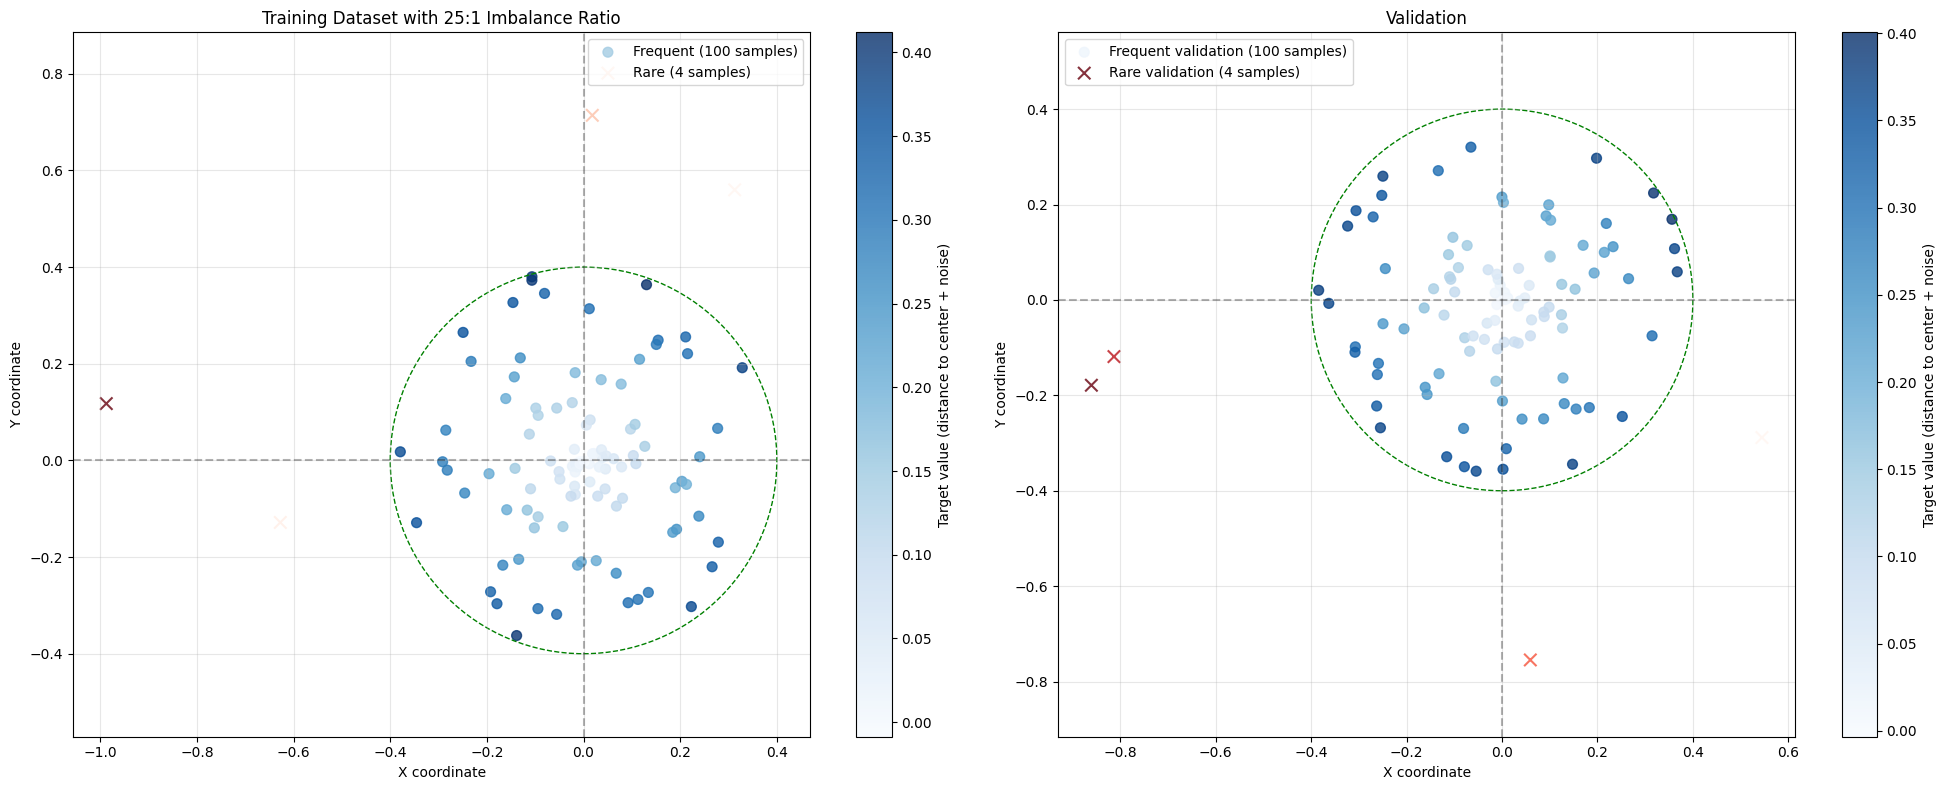

Training model with 104 training samples and 104 validation samples
Training data features shape: (104, 2), Validation data features shape: (104, 2)
Training data targets shape: (104,), Validation data targets shape: (104,)
Learning rate: 0.01, Batch size: 8, Epochs: 10
Y threshold for frequent vs rare: 0.5
Using sample weights for training (shape: (104,))
Using sample weights for validation (shape: (104,))
Model compiled with Adam optimizer (lr=0.01) and MSE loss
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                 

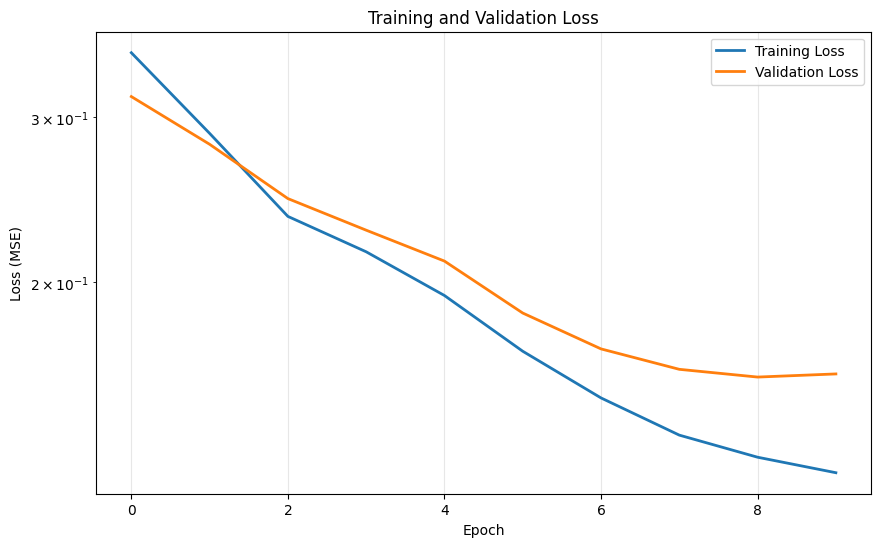

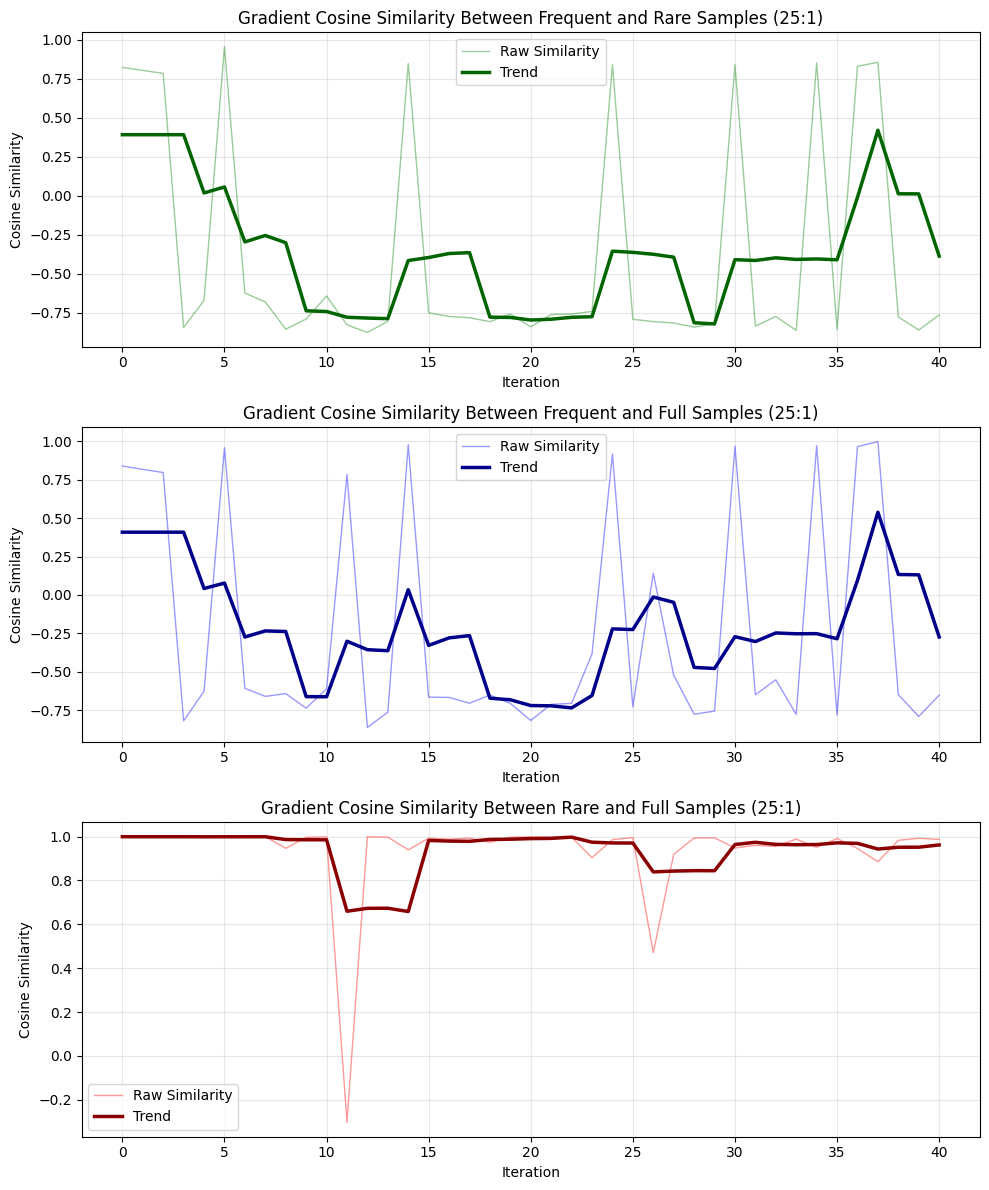

In [ ]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 25

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=True
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=0.001)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=sample_weights_train,
    sample_weights_val=sample_weights_val,
    epochs=10, batch_size=8, lr=0.01,
    y_threshold=y_threshold, debug=True
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio)


In [63]:

# Configuration
num_freq_in_train = 10000
num_freq_in_val = 10000
freq_max_radius = 0.4
rare_min_radius = 0.6
noise_level = 0.01
y_threshold = 0.5

epochs = 100
# batch_size = 4096 # no batches
lr = 0.01
weight_decay = 0.1


# Generate dataset
dataset = ImbalancedCircleDataset(
    num_freq_in_train=num_freq_in_train,
    num_freq_in_val=num_freq_in_val,
    freq_max_radius=freq_max_radius,
    rare_min_radius=rare_min_radius,
    noise_level=noise_level,
)



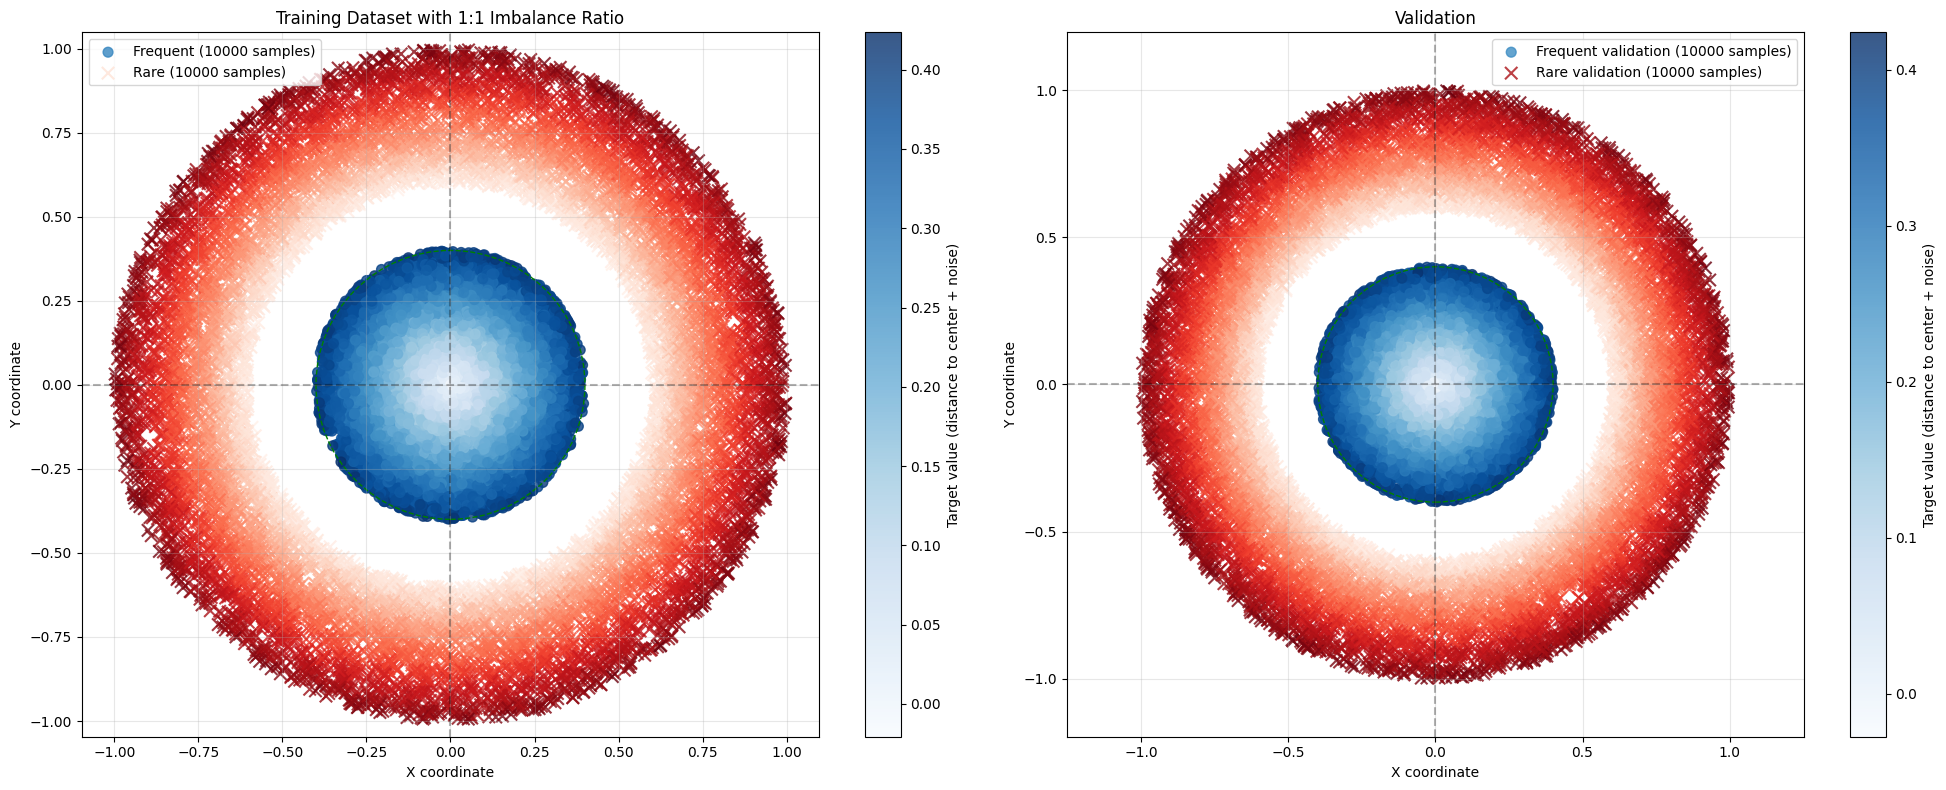

Training model with 20000 training samples and 20000 validation samples
Epoch 1/100 -               train_loss: 0.176356 - val_loss: 0.175081 -               num_params: 9 - param_norm: 1.7489
Epoch 2/100 -               train_loss: 0.157162 - val_loss: 0.155891 -               num_params: 9 - param_norm: 1.7691
Epoch 3/100 -               train_loss: 0.139426 - val_loss: 0.138170 -               num_params: 9 - param_norm: 1.7896
Epoch 4/100 -               train_loss: 0.123288 - val_loss: 0.122063 -               num_params: 9 - param_norm: 1.8103
Epoch 5/100 -               train_loss: 0.108861 - val_loss: 0.107667 -               num_params: 9 - param_norm: 1.8312
Epoch 6/100 -               train_loss: 0.096242 - val_loss: 0.095085 -               num_params: 9 - param_norm: 1.8522
Epoch 7/100 -               train_loss: 0.085504 - val_loss: 0.084397 -               num_params: 9 - param_norm: 1.8732
Epoch 8/100 -               train_loss: 0.076690 - val_loss: 0.075643 -          

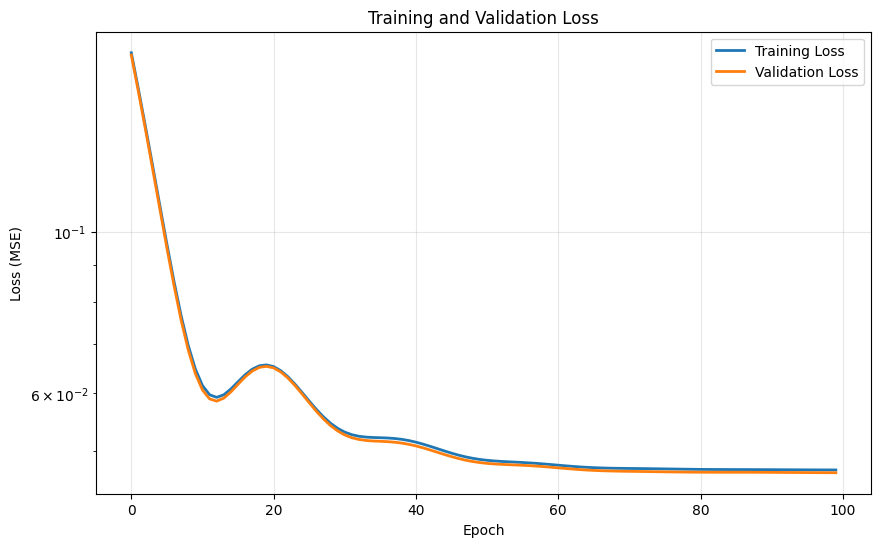

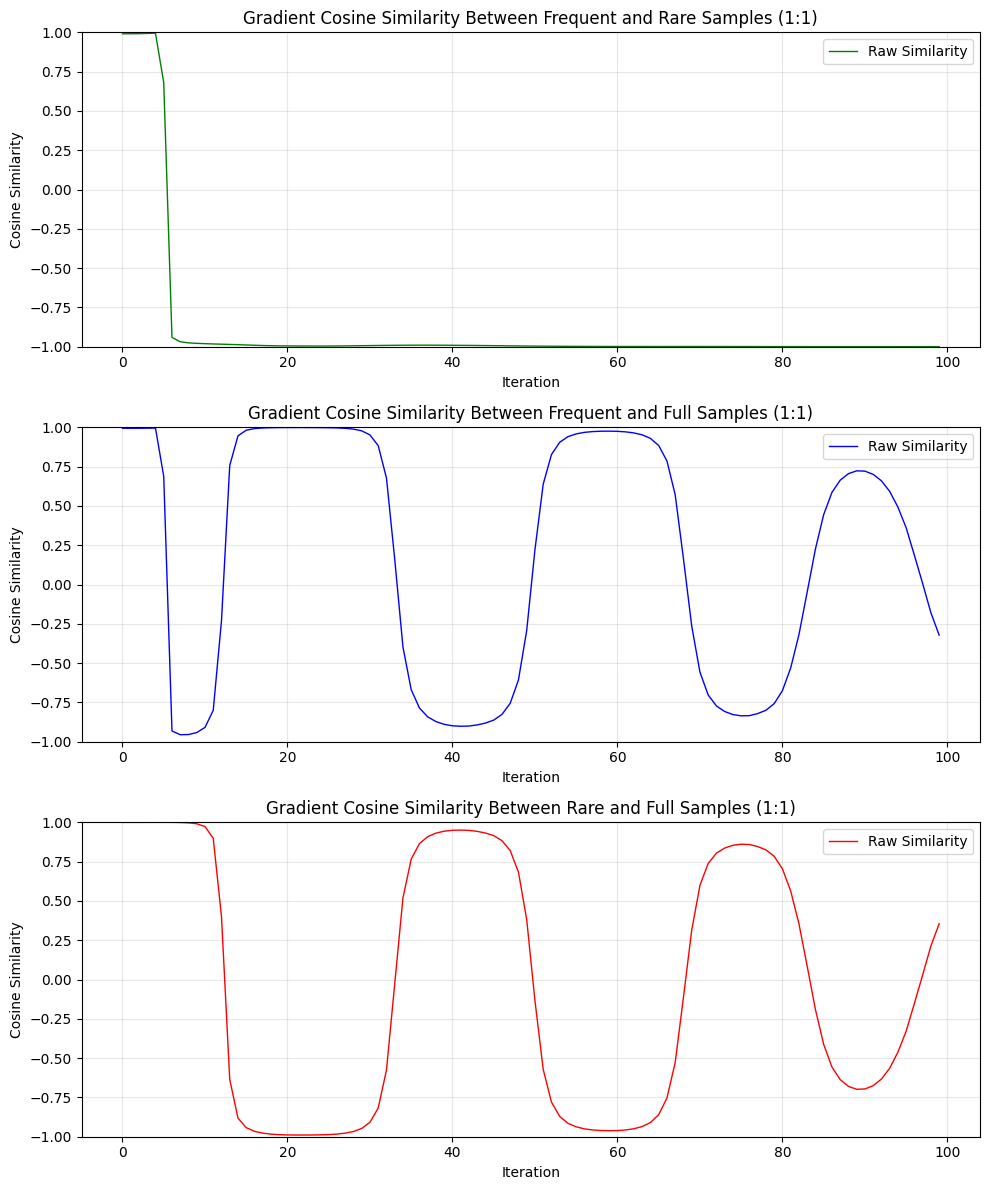

In [68]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 1

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=None, # sample_weights_train,
    sample_weights_val=None, # sample_weights_val,
    epochs=epochs, batch_size=20000, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)


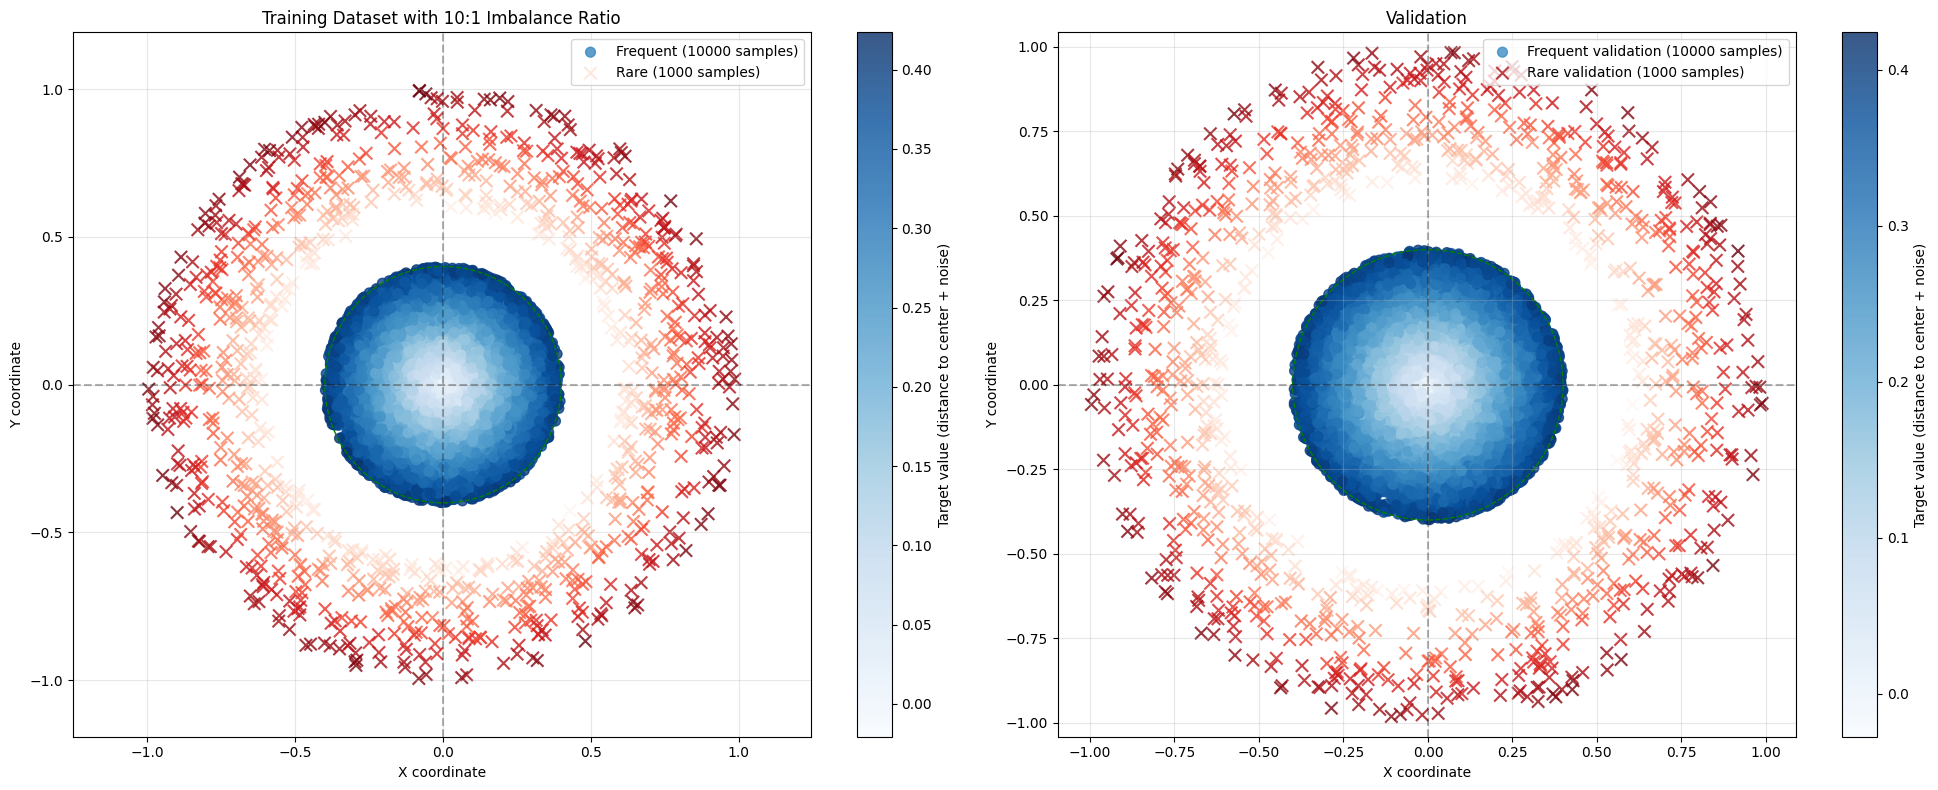

Training model with 11000 training samples and 11000 validation samples
Epoch 1/100 -               train_loss: 0.196535 - val_loss: 0.194144 -               num_params: 9 - param_norm: 1.8422
Epoch 2/100 -               train_loss: 0.181351 - val_loss: 0.179097 -               num_params: 9 - param_norm: 1.8214
Epoch 3/100 -               train_loss: 0.167369 - val_loss: 0.165251 -               num_params: 9 - param_norm: 1.8010
Epoch 4/100 -               train_loss: 0.154543 - val_loss: 0.152553 -               num_params: 9 - param_norm: 1.7810
Epoch 5/100 -               train_loss: 0.142819 - val_loss: 0.140955 -               num_params: 9 - param_norm: 1.7614
Epoch 6/100 -               train_loss: 0.132138 - val_loss: 0.130399 -               num_params: 9 - param_norm: 1.7424
Epoch 7/100 -               train_loss: 0.122450 - val_loss: 0.120828 -               num_params: 9 - param_norm: 1.7239
Epoch 8/100 -               train_loss: 0.113690 - val_loss: 0.112182 -          

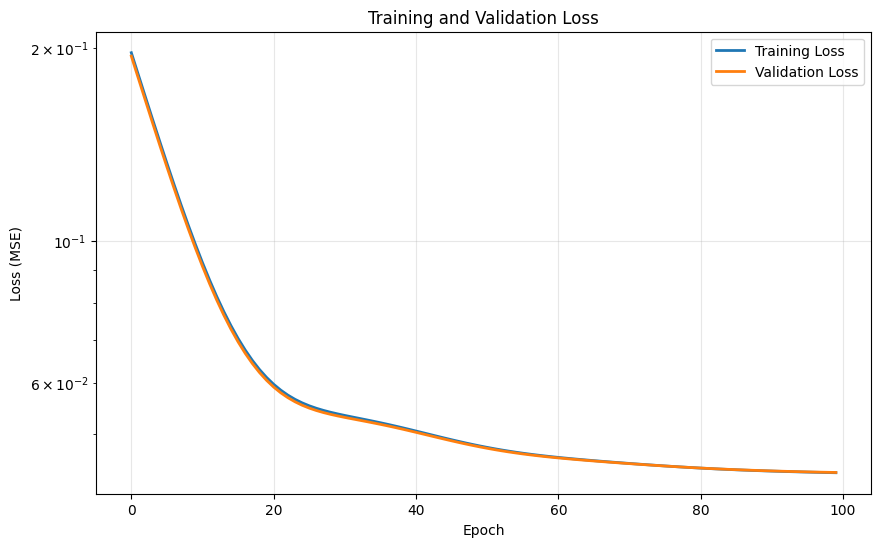

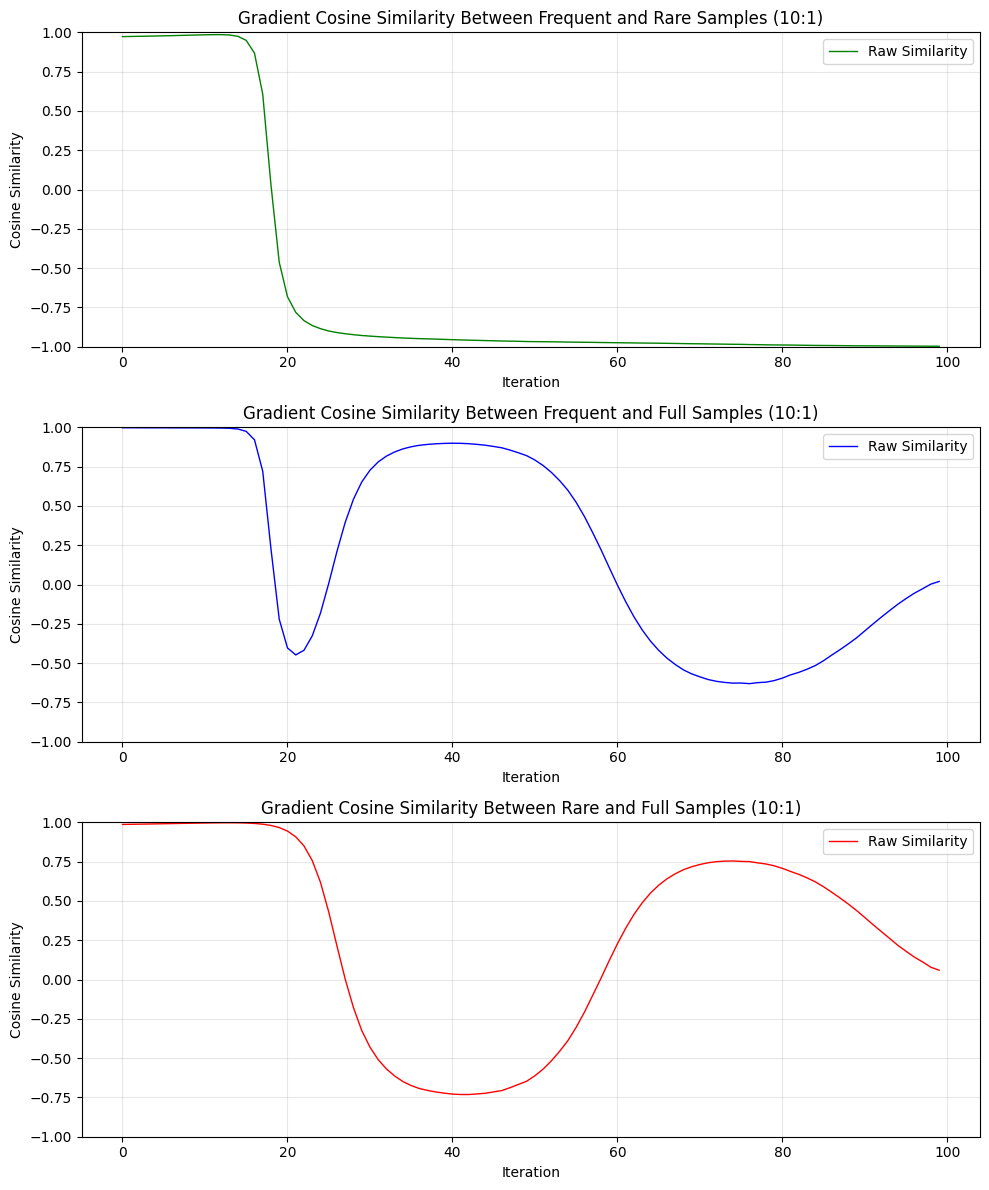

In [65]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 10

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=None,
    sample_weights_val=None,
    epochs=epochs, batch_size=11000, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)


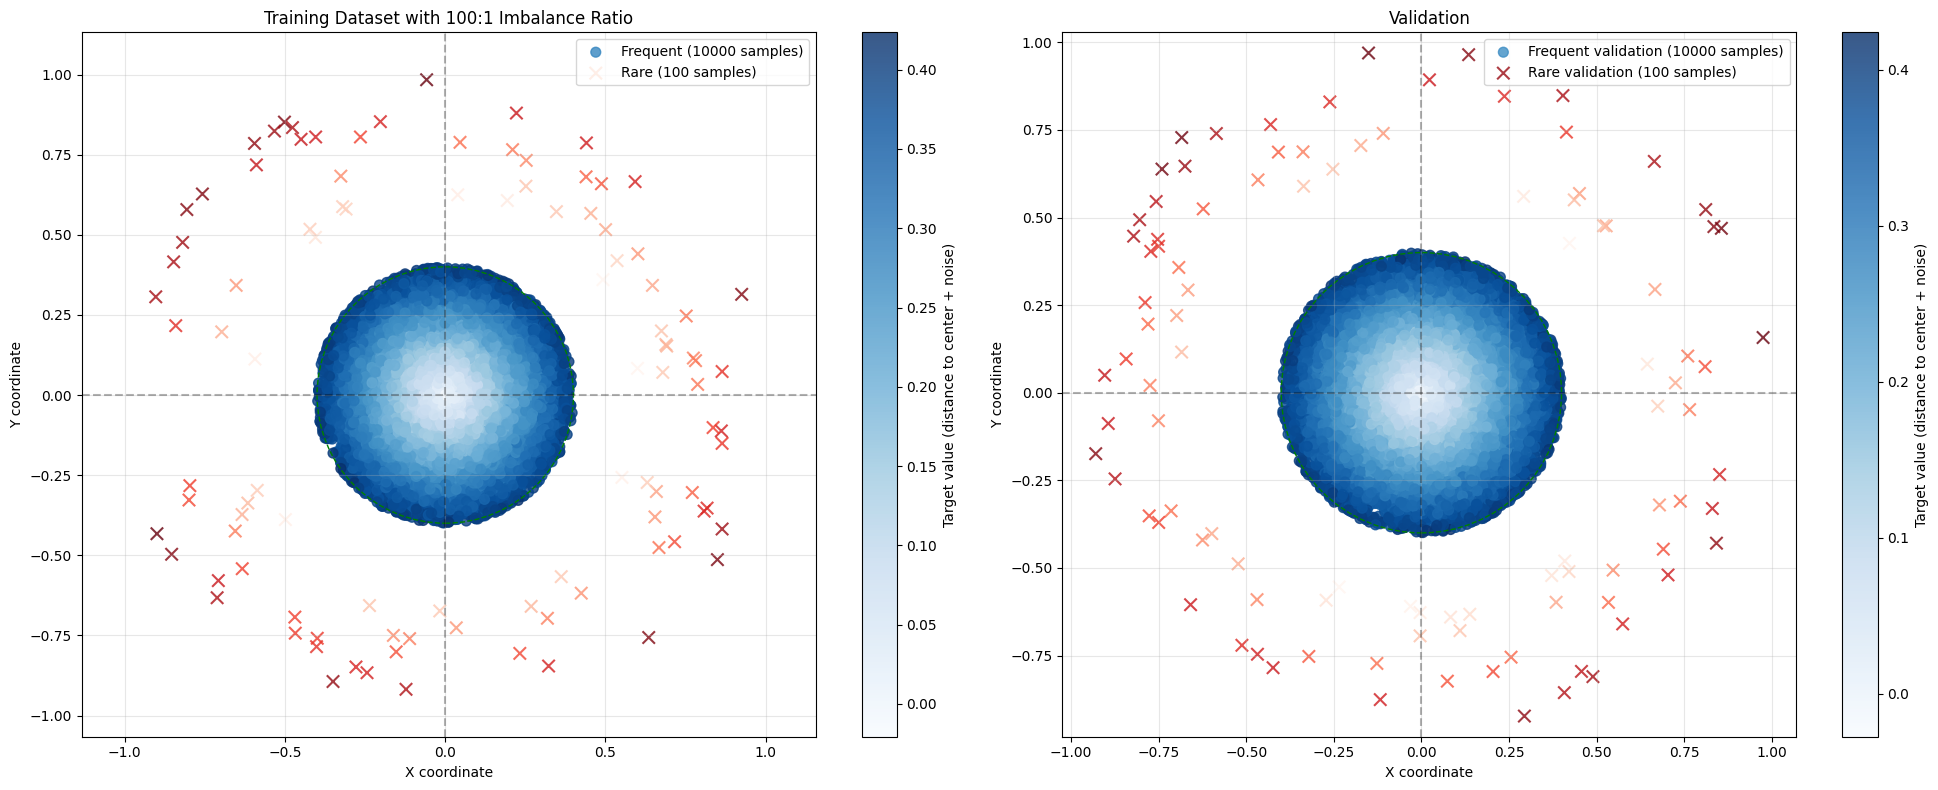

Training model with 10100 training samples and 10100 validation samples
Epoch 1/100 -               train_loss: 0.057136 - val_loss: 0.056498 -               num_params: 9 - param_norm: 2.1559
Epoch 2/100 -               train_loss: 0.050142 - val_loss: 0.049559 -               num_params: 9 - param_norm: 2.1527
Epoch 3/100 -               train_loss: 0.044375 - val_loss: 0.043844 -               num_params: 9 - param_norm: 2.1495
Epoch 4/100 -               train_loss: 0.039809 - val_loss: 0.039320 -               num_params: 9 - param_norm: 2.1457
Epoch 5/100 -               train_loss: 0.036332 - val_loss: 0.035878 -               num_params: 9 - param_norm: 2.1401
Epoch 6/100 -               train_loss: 0.033783 - val_loss: 0.033354 -               num_params: 9 - param_norm: 2.1328
Epoch 7/100 -               train_loss: 0.031991 - val_loss: 0.031583 -               num_params: 9 - param_norm: 2.1245
Epoch 8/100 -               train_loss: 0.030785 - val_loss: 0.030394 -          

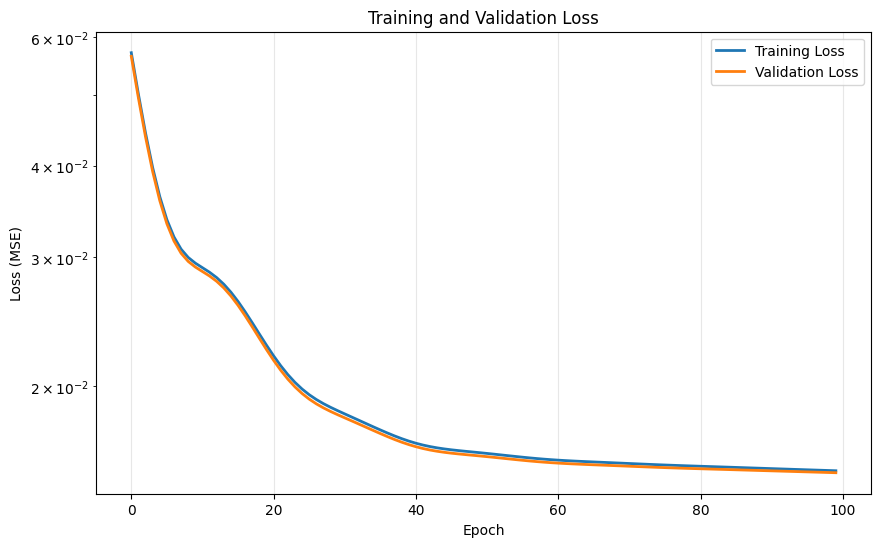

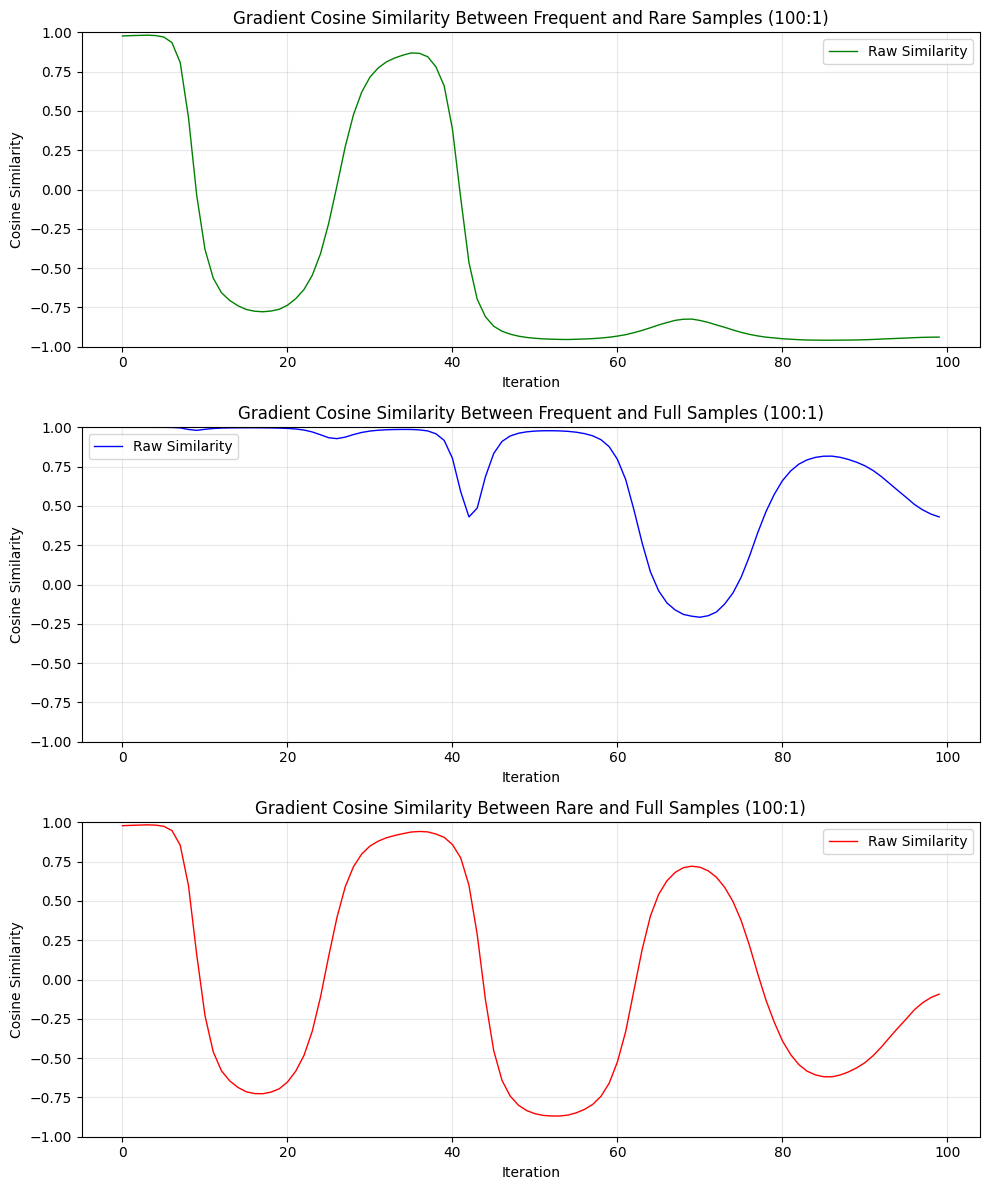

In [66]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 100

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=None,
    sample_weights_val=None,
    epochs=epochs, batch_size=10100, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)


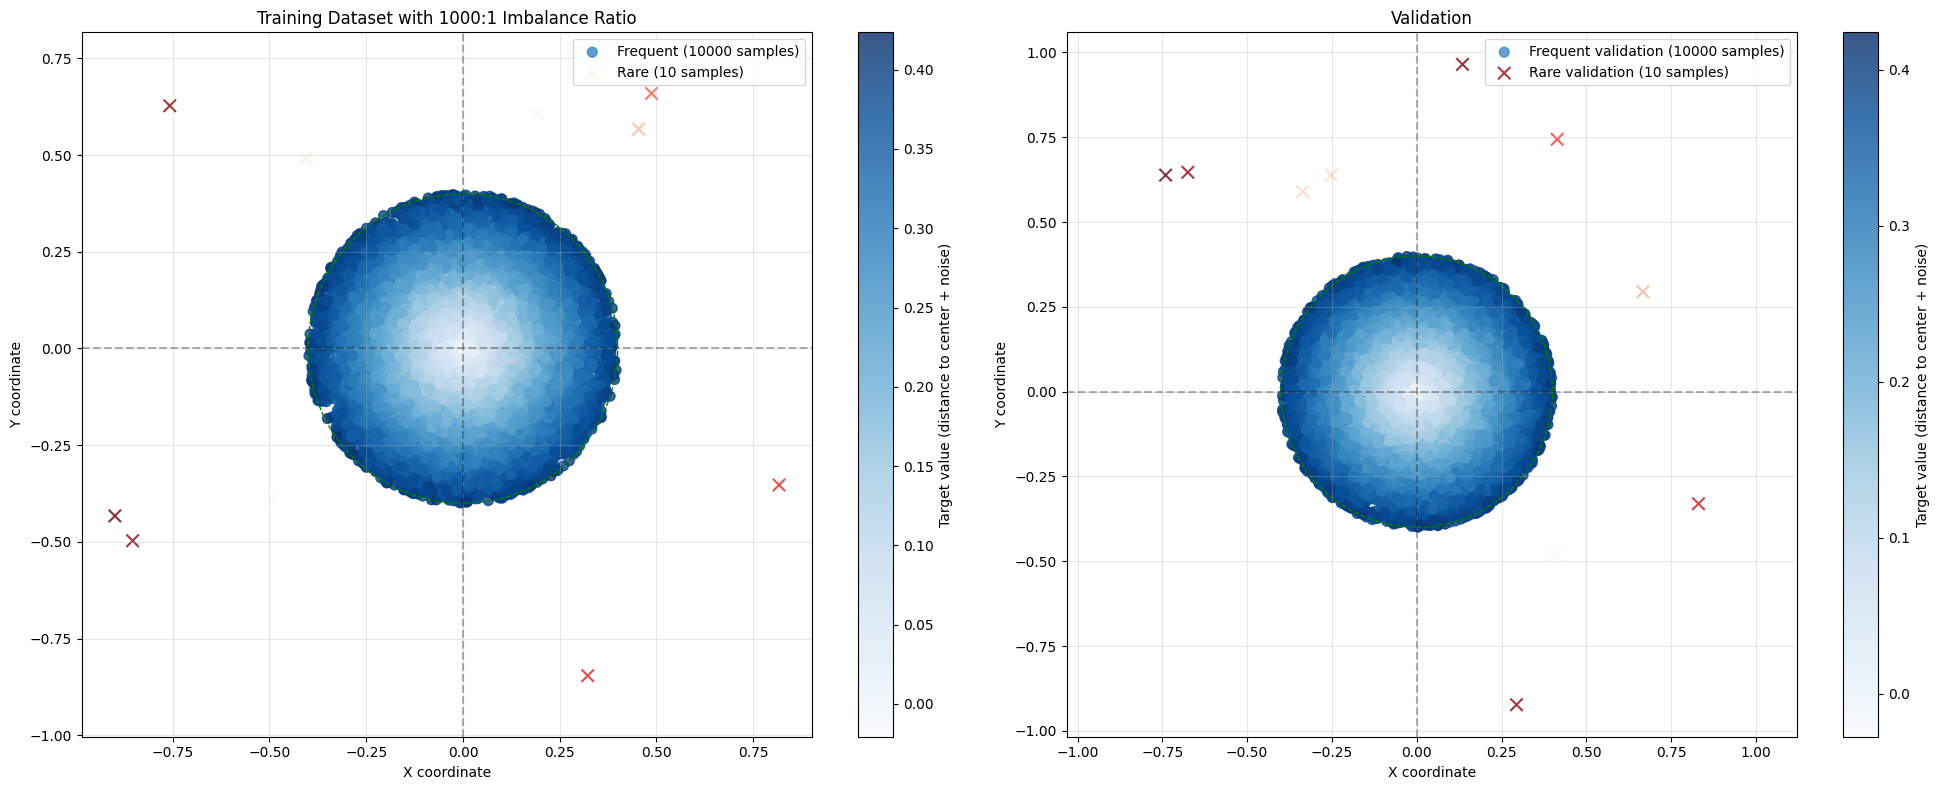

Training model with 10010 training samples and 10010 validation samples
Epoch 1/100 -               train_loss: 0.041856 - val_loss: 0.041891 -               num_params: 9 - param_norm: 1.6705
Epoch 2/100 -               train_loss: 0.037487 - val_loss: 0.037514 -               num_params: 9 - param_norm: 1.6900
Epoch 3/100 -               train_loss: 0.033511 - val_loss: 0.033533 -               num_params: 9 - param_norm: 1.7095
Epoch 4/100 -               train_loss: 0.029965 - val_loss: 0.029983 -               num_params: 9 - param_norm: 1.7286
Epoch 5/100 -               train_loss: 0.026885 - val_loss: 0.026900 -               num_params: 9 - param_norm: 1.7464
Epoch 6/100 -               train_loss: 0.024298 - val_loss: 0.024311 -               num_params: 9 - param_norm: 1.7617
Epoch 7/100 -               train_loss: 0.022218 - val_loss: 0.022232 -               num_params: 9 - param_norm: 1.7738
Epoch 8/100 -               train_loss: 0.020638 - val_loss: 0.020654 -          

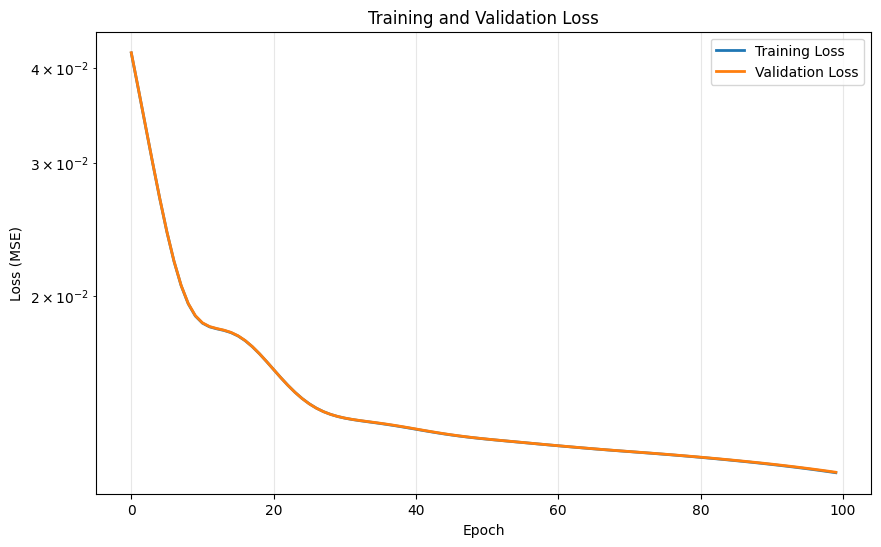

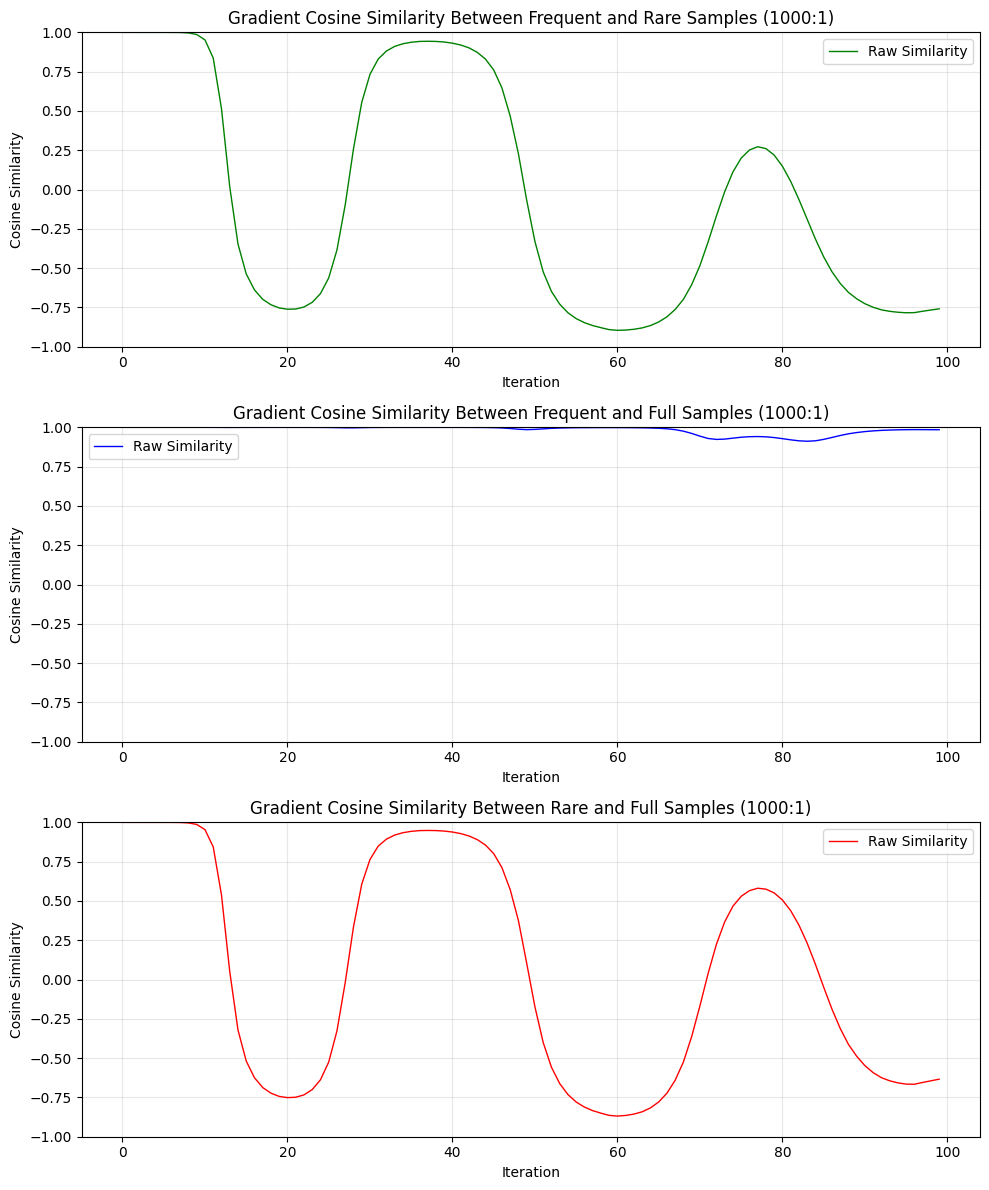

In [67]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 1000

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=None, # sample_weights_train,
    sample_weights_val=None, # sample_weights_val,
    epochs=epochs, batch_size=10010, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)


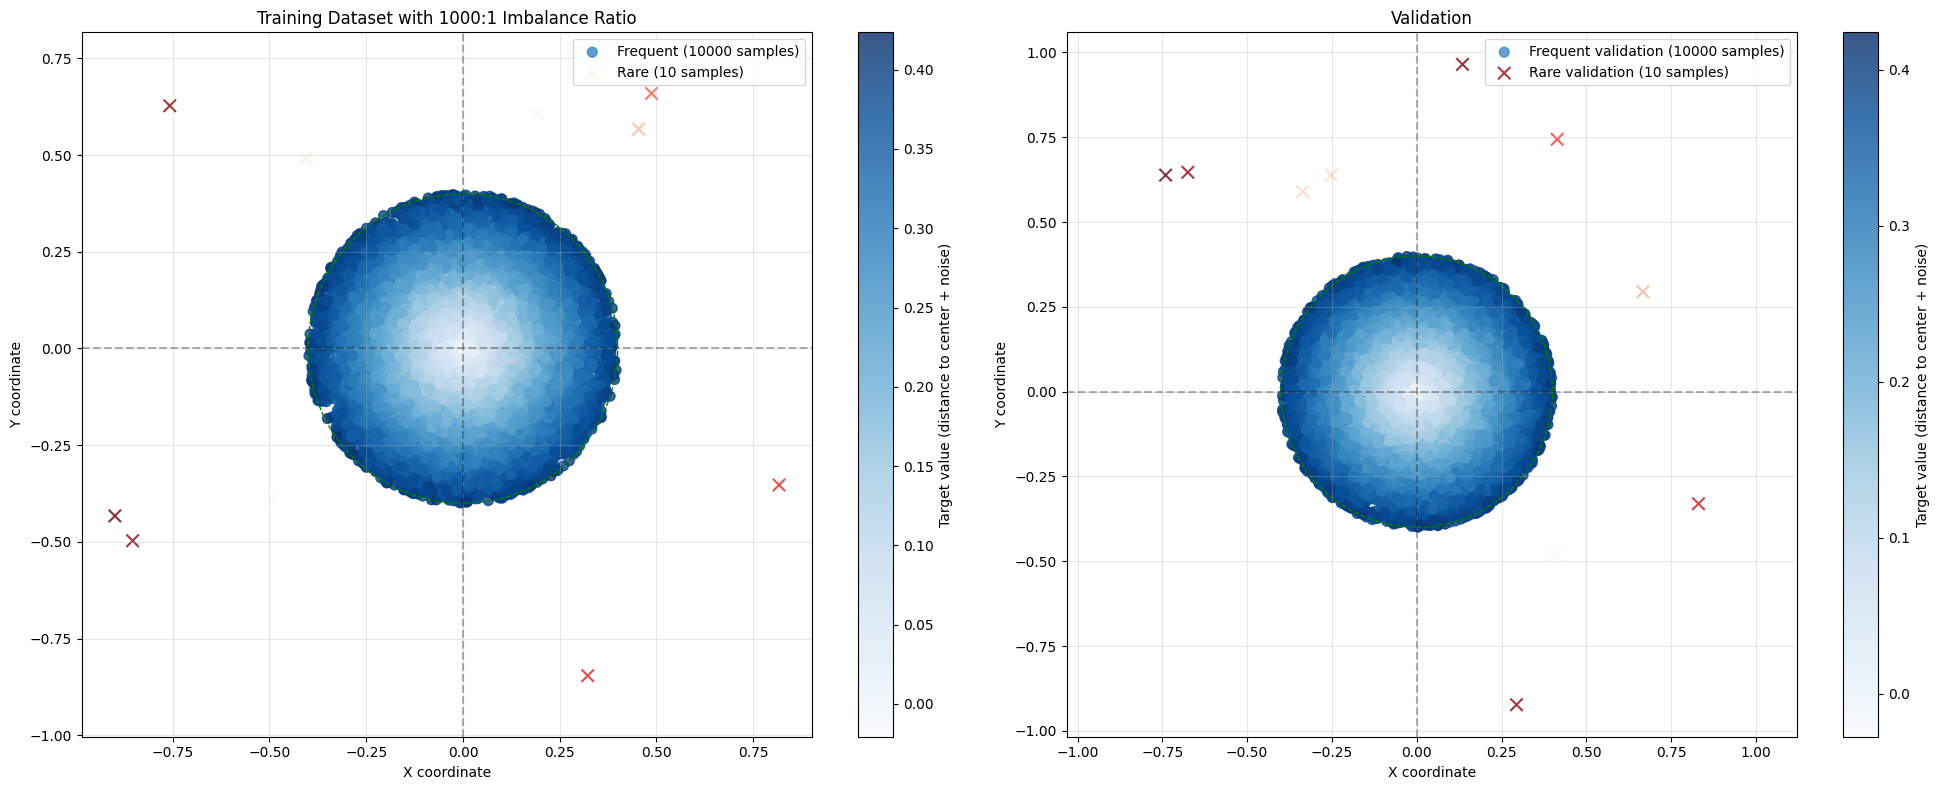

Training model with 10010 training samples and 10010 validation samples
Epoch 1/100 -               train_loss: 0.437302 - val_loss: 0.482220 -               num_params: 9 - param_norm: 1.2746
Epoch 2/100 -               train_loss: 0.414603 - val_loss: 0.457701 -               num_params: 9 - param_norm: 1.2632
Epoch 3/100 -               train_loss: 0.392763 - val_loss: 0.434250 -               num_params: 9 - param_norm: 1.2526
Epoch 4/100 -               train_loss: 0.371790 - val_loss: 0.411867 -               num_params: 9 - param_norm: 1.2427
Epoch 5/100 -               train_loss: 0.351692 - val_loss: 0.390550 -               num_params: 9 - param_norm: 1.2336
Epoch 6/100 -               train_loss: 0.332472 - val_loss: 0.370293 -               num_params: 9 - param_norm: 1.2252
Epoch 7/100 -               train_loss: 0.314131 - val_loss: 0.351087 -               num_params: 9 - param_norm: 1.2177
Epoch 8/100 -               train_loss: 0.296671 - val_loss: 0.332923 -          

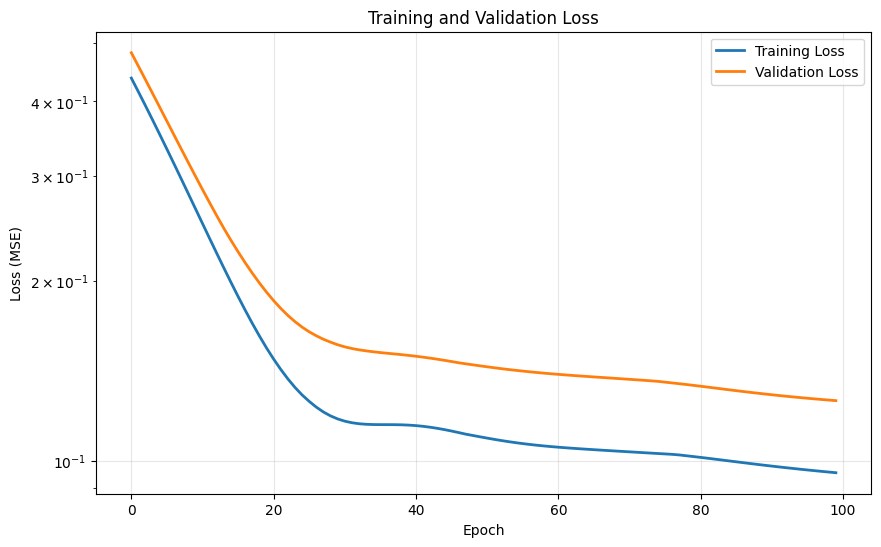

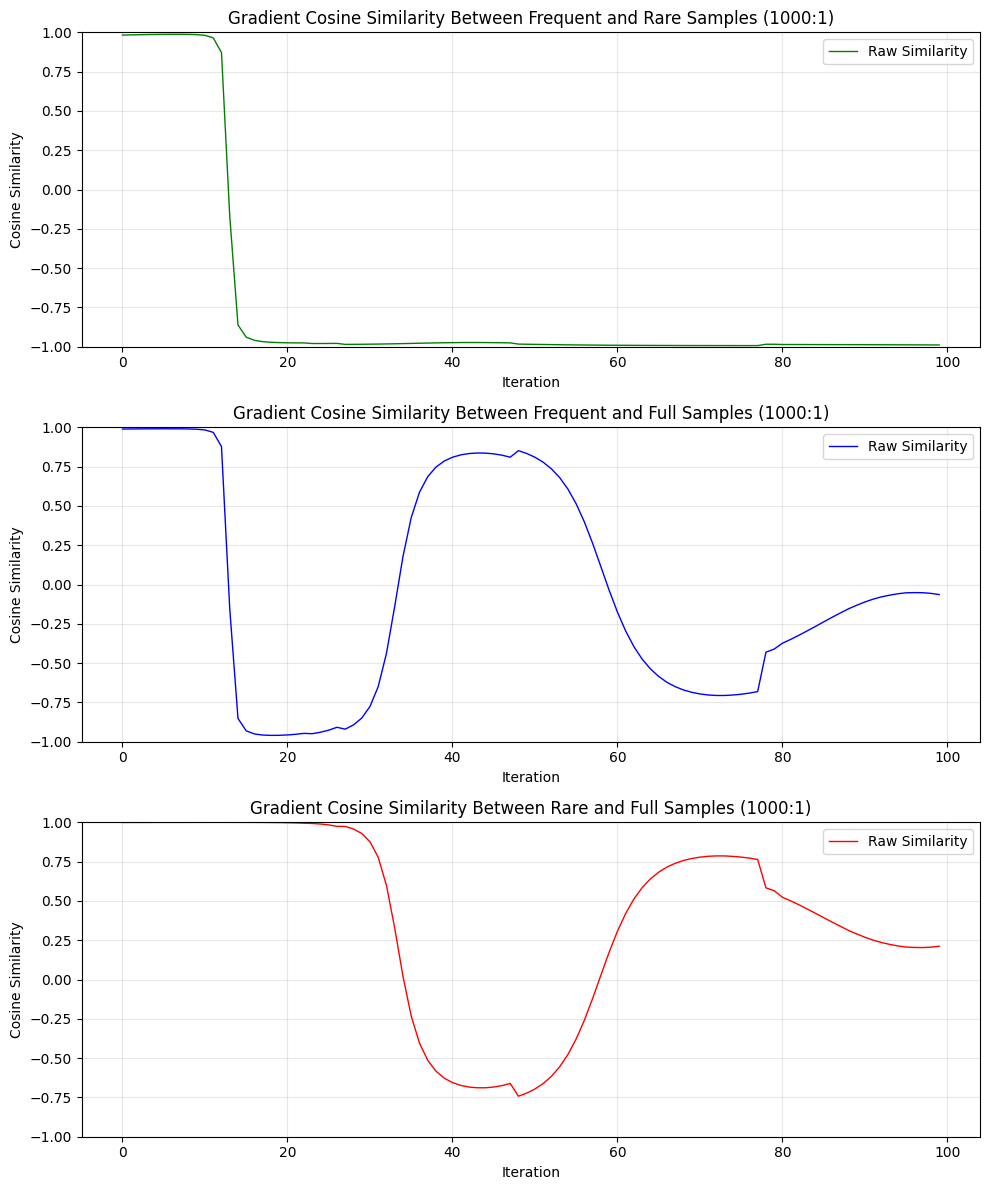

In [69]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 1000

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=sample_weights_train,
    sample_weights_val=sample_weights_val,
    epochs=epochs, batch_size=10010, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)

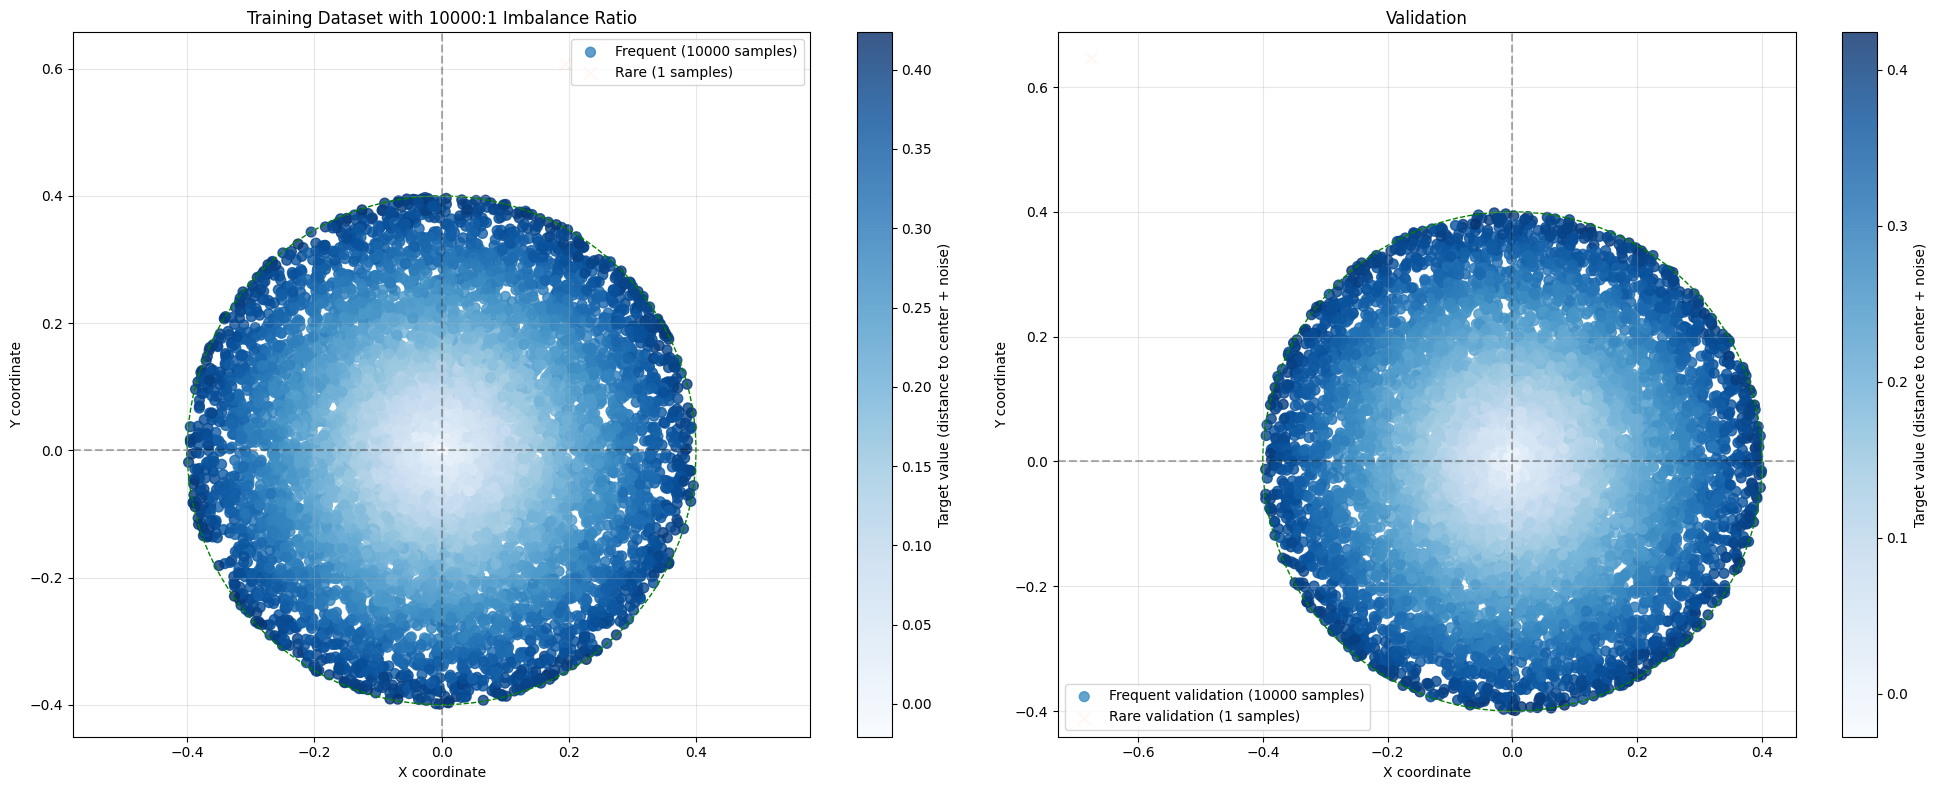

Training model with 10001 training samples and 10001 validation samples
Epoch 1/100 -               train_loss: 0.456169 - val_loss: 1.659941 -               num_params: 9 - param_norm: 1.8900
Epoch 2/100 -               train_loss: 0.414991 - val_loss: 1.593053 -               num_params: 9 - param_norm: 1.8901
Epoch 3/100 -               train_loss: 0.376309 - val_loss: 1.528380 -               num_params: 9 - param_norm: 1.8907
Epoch 4/100 -               train_loss: 0.340088 - val_loss: 1.465961 -               num_params: 9 - param_norm: 1.8918
Epoch 5/100 -               train_loss: 0.306293 - val_loss: 1.405837 -               num_params: 9 - param_norm: 1.8935
Epoch 6/100 -               train_loss: 0.274881 - val_loss: 1.348037 -               num_params: 9 - param_norm: 1.8957
Epoch 7/100 -               train_loss: 0.245795 - val_loss: 1.292585 -               num_params: 9 - param_norm: 1.8984
Epoch 8/100 -               train_loss: 0.218977 - val_loss: 1.239496 -          

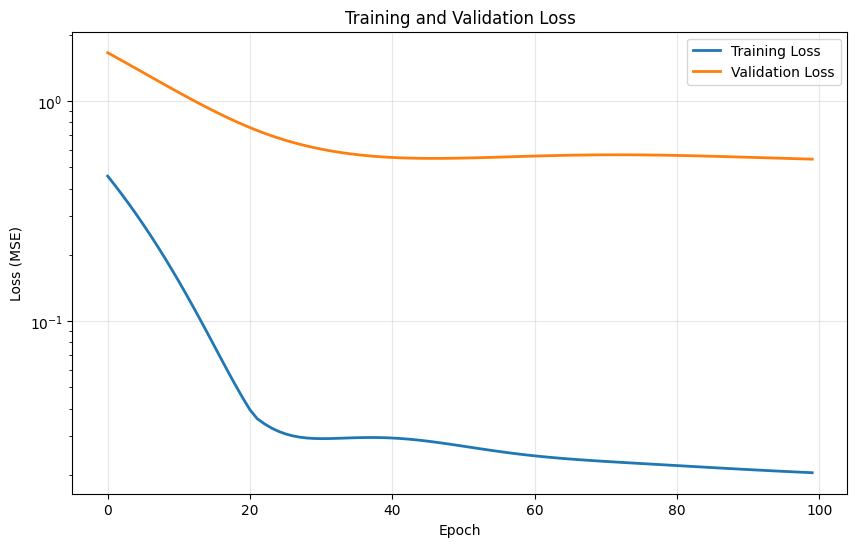

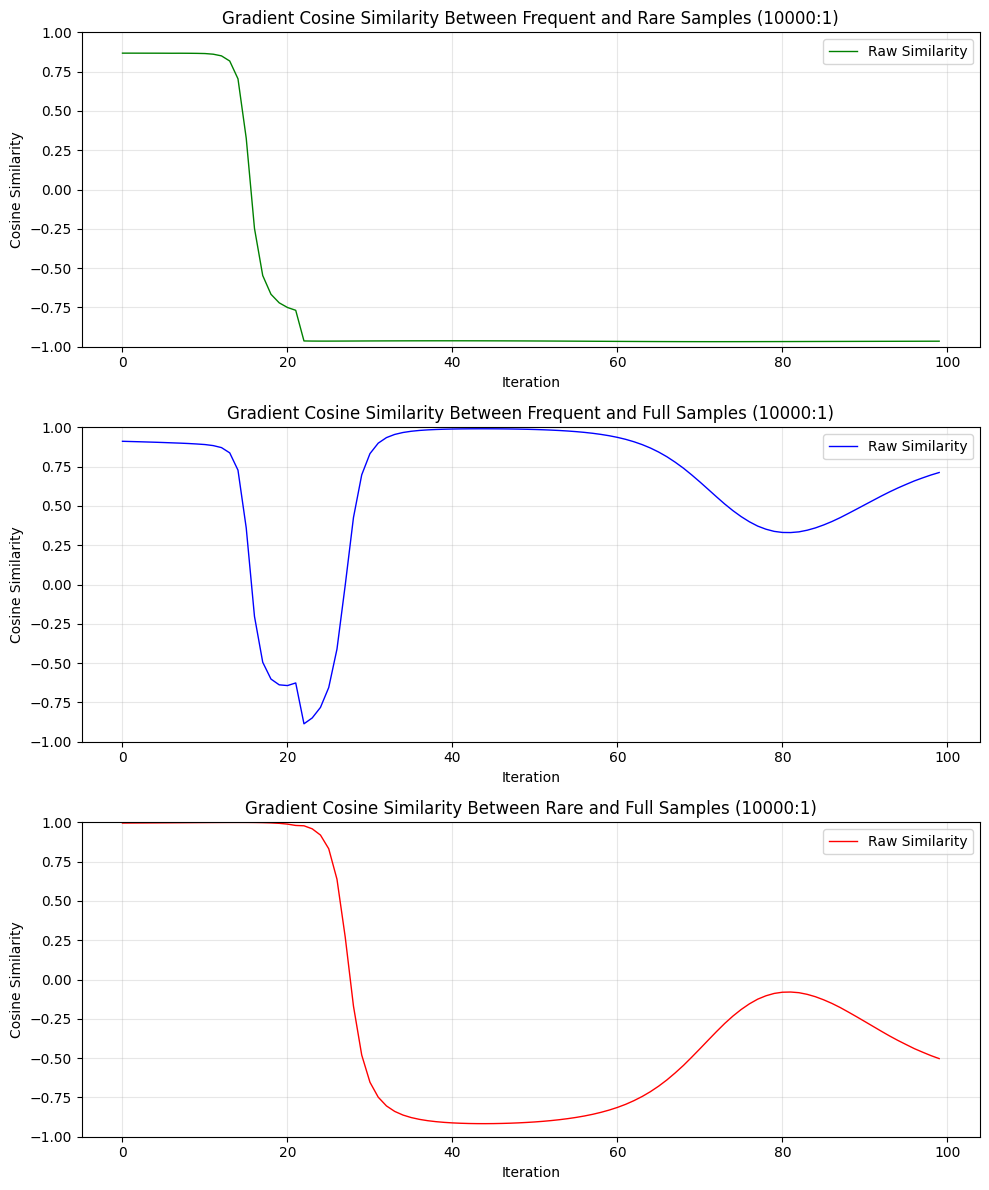

In [71]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 10000

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=sample_weights_train,
    sample_weights_val=sample_weights_val,
    epochs=epochs, batch_size=10001, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=False)

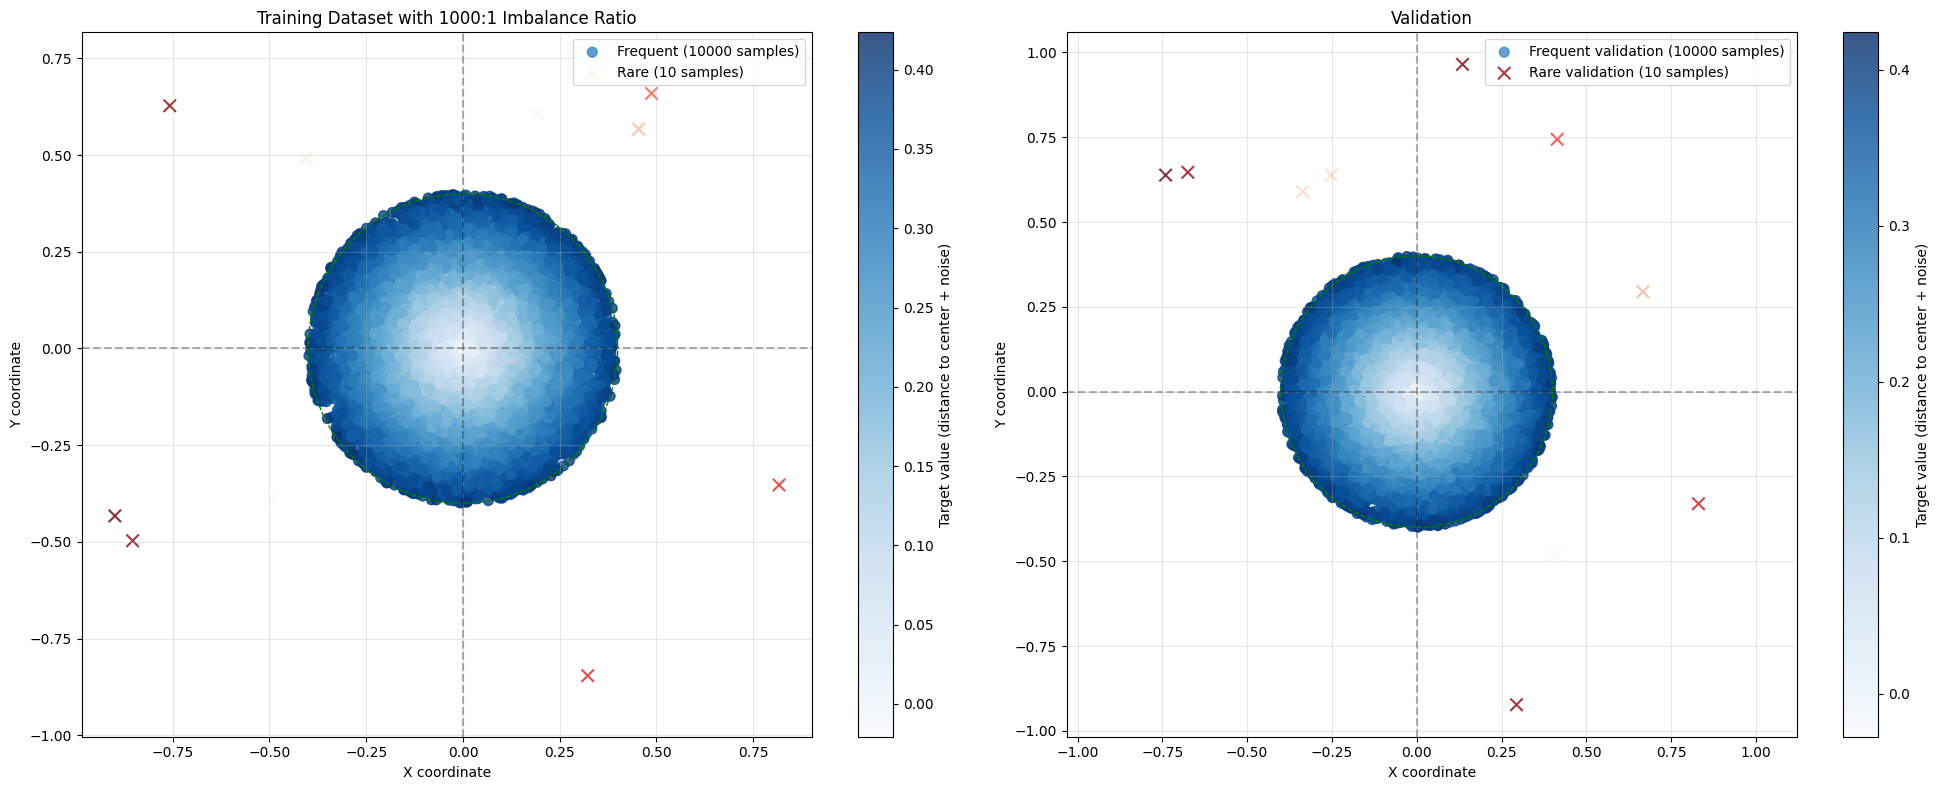

Training model with 10010 training samples and 10010 validation samples
Epoch 1/100 -               train_loss: 0.468822 - val_loss: 0.263618 -               num_params: 9 - param_norm: 1.9397
Epoch 2/100 -               train_loss: 0.381584 - val_loss: 0.213919 -               num_params: 9 - param_norm: 1.8694
Epoch 3/100 -               train_loss: 0.320561 - val_loss: 0.182653 -               num_params: 9 - param_norm: 1.8088
Epoch 4/100 -               train_loss: 0.272553 - val_loss: 0.163153 -               num_params: 9 - param_norm: 1.7485
Epoch 5/100 -               train_loss: 0.236381 - val_loss: 0.147097 -               num_params: 9 - param_norm: 1.6897
Epoch 6/100 -               train_loss: 0.213150 - val_loss: 0.137651 -               num_params: 9 - param_norm: 1.6393
Epoch 7/100 -               train_loss: 0.196398 - val_loss: 0.130960 -               num_params: 9 - param_norm: 1.5960
Epoch 8/100 -               train_loss: 0.180322 - val_loss: 0.124665 -          

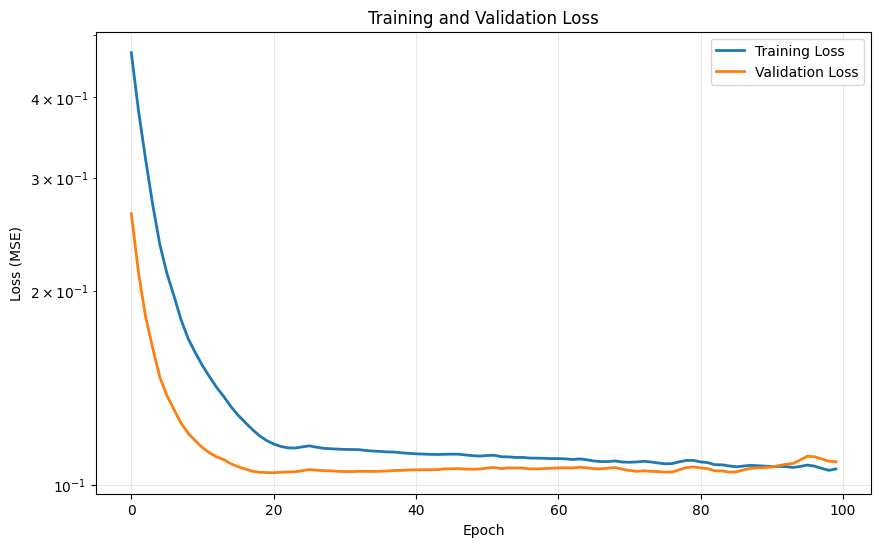

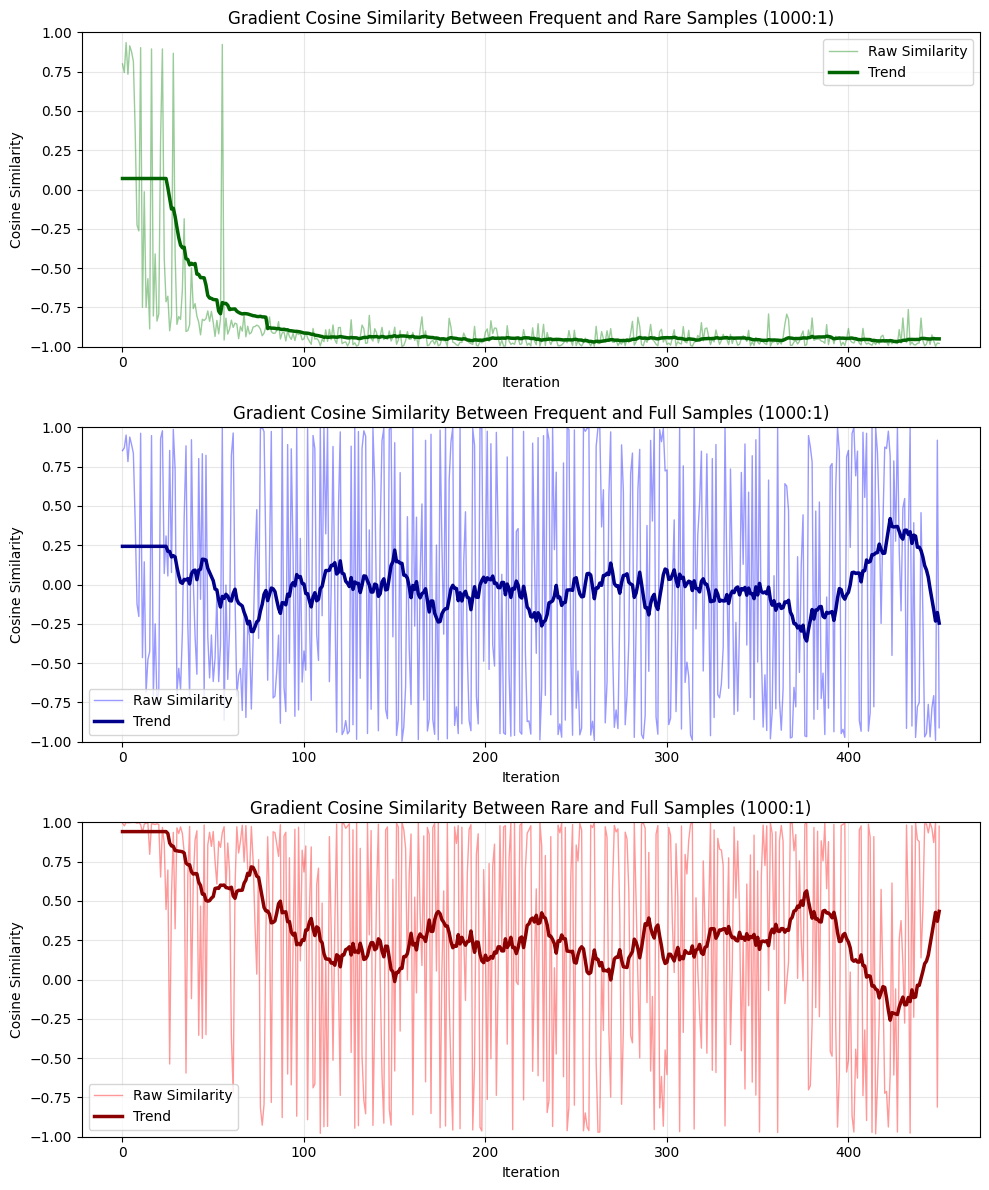

In [73]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 1000

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=sample_weights_train,
    sample_weights_val=sample_weights_val,
    epochs=epochs, batch_size=2002, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=True)

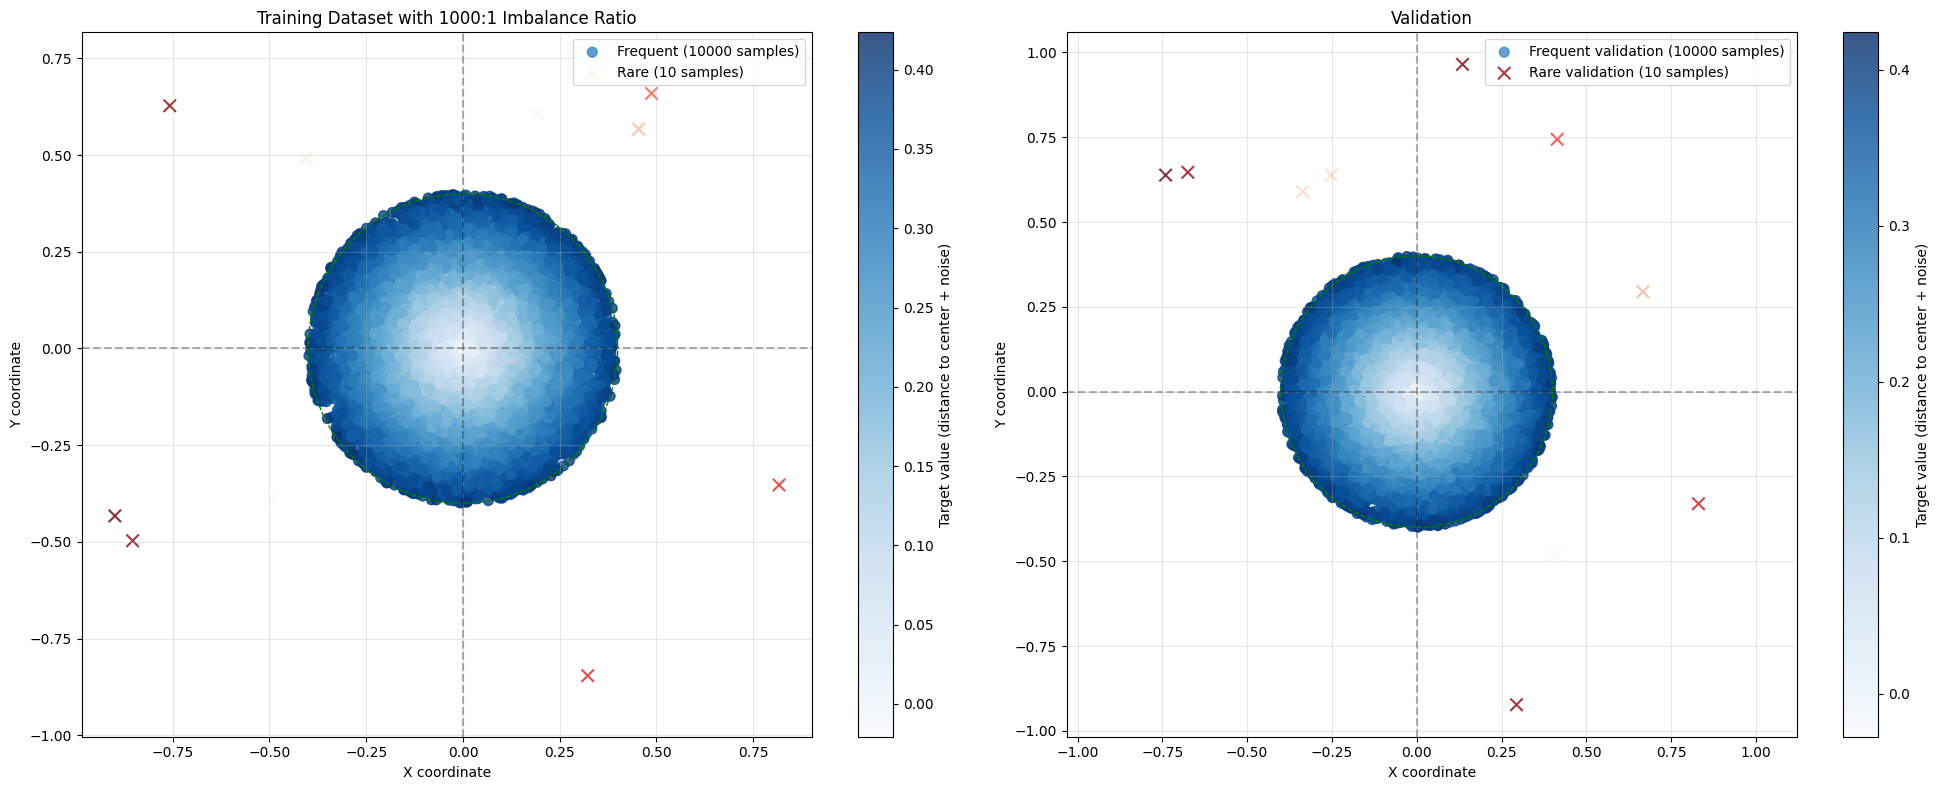

Training model with 10010 training samples and 10010 validation samples
Epoch 1/100 -               train_loss: 0.048807 - val_loss: 0.048104 -               num_params: 9 - param_norm: 1.8086
Epoch 2/100 -               train_loss: 0.030945 - val_loss: 0.030387 -               num_params: 9 - param_norm: 1.7137
Epoch 3/100 -               train_loss: 0.026020 - val_loss: 0.025631 -               num_params: 9 - param_norm: 1.6246
Epoch 4/100 -               train_loss: 0.021574 - val_loss: 0.021276 -               num_params: 9 - param_norm: 1.5395
Epoch 5/100 -               train_loss: 0.017483 - val_loss: 0.017243 -               num_params: 9 - param_norm: 1.4633
Epoch 6/100 -               train_loss: 0.015509 - val_loss: 0.015317 -               num_params: 9 - param_norm: 1.4038
Epoch 7/100 -               train_loss: 0.014788 - val_loss: 0.014625 -               num_params: 9 - param_norm: 1.3638
Epoch 8/100 -               train_loss: 0.014207 - val_loss: 0.014048 -          

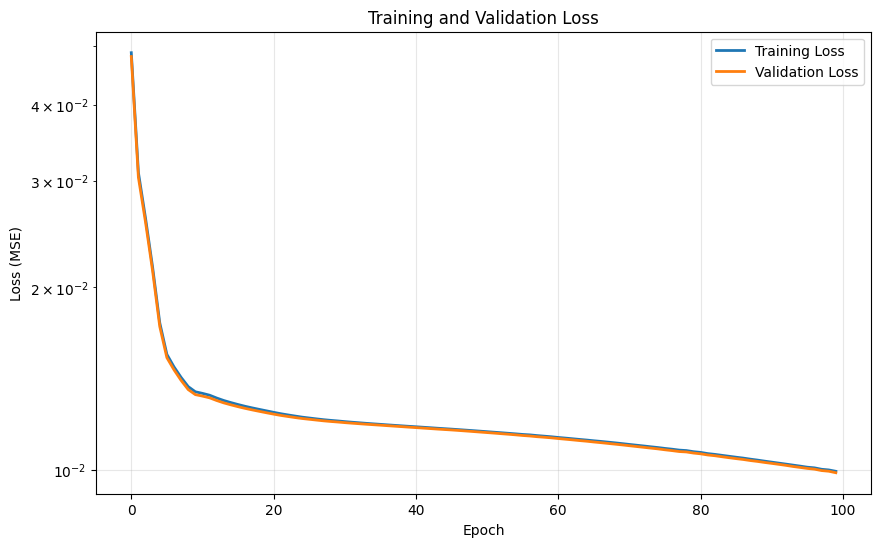

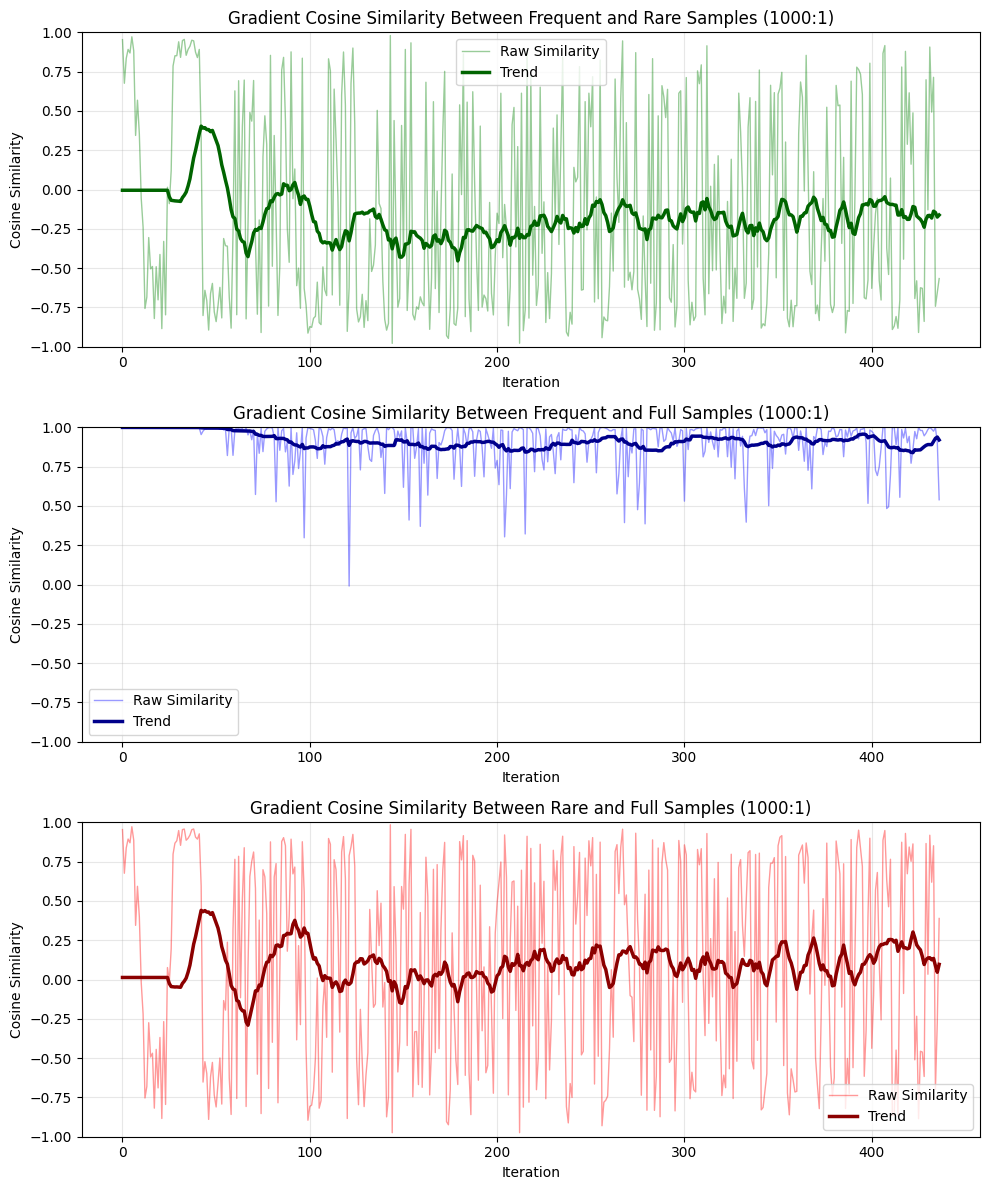

In [74]:
# Run a test with an imbalance ratio and plot the results including cosine similarity
imb_ratio = 1000

# Test with a specific imbalance ratio
X_train, y_train, sample_weights_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(imbalance_ratio=imb_ratio)

# Plot dataset
plot_dataset(
    X_train, y_train, 
    X_val, y_val, 
    y_threshold=y_threshold,
    freq_max_radius=freq_max_radius,
    title=f"Dataset with {imb_ratio}:1 Imbalance Ratio",
    debug=False
)

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)
# Pass the freq_mask so gradient cosine similarity can be calculated
history = train_model(
    model, X_train, y_train, X_val, y_val, 
    sample_weights_train=None, # sample_weights_train,
    sample_weights_val=None, # sample_weights_val,
    epochs=epochs, batch_size=2002, lr=lr,
    y_threshold=y_threshold, debug=False
)  

# Plot results
plot_training_curves(history)


# Call the function with the current history
plot_gradient_cosine_similarities(history, imb_ratio, trend=True)